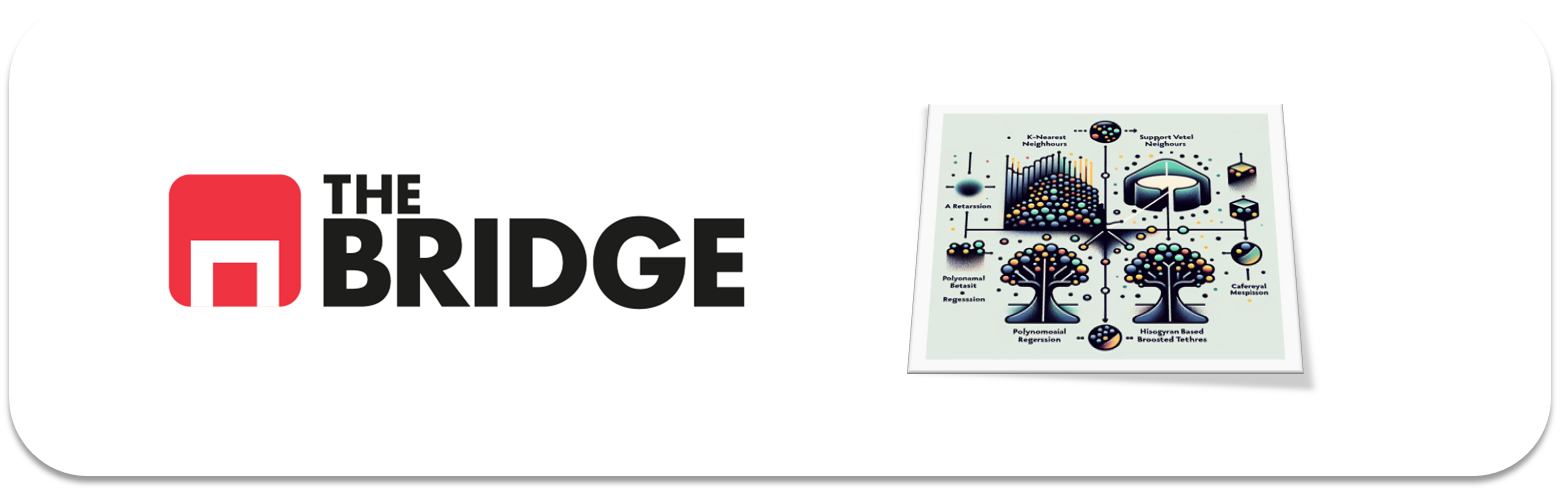

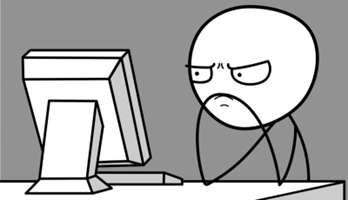

Para hacer un **repaso a los problemas de clasificacion con ML**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### INTRODUCCIóN: PROCESO DE ML

En los siguientes ejercicios vamos a seguir (de nuevo) los pasos básicos en la creación de un modelo de ML para resolver un problema de predicción a partir de un dataset que incluye el target, es decir, un aprendizaje supervisado.

En concreto, vamos a trabajar sobre un problema de clasificación a través de los siguientes pasos:

1. Entendimiento del problema (selección de la métrica más adecuada)  
2. Obtención de datos y primer contacto  
3. Train y Test  
4. MiniEDA: Análisis del target, análisis bivariante, entendimiento de las features, selección de las mismas (si es necesario)  
5. Preparación del dataset de Train: Conversión de categóricas, tratamiento de numéricas  
6. Selección e instanciación de modelos. Baseline.
7. Comparación de modelos (lo haremos por comparación con validación, puedes hacerlo por comparación de modelos de hiperparámetros optimizados, si así lo prefieres)  
8. Selección de modelo: Optimización de hiperparámetros (ten en cuenta la nota de 7)  
9. Equilibrado del train set  
10. Evaluación contra test.  
11. Análisis de errores, posibles acciones futuras.  
12. EXTRA: Persistencia del modelo en disco.  

### El problema

La unidad oncológica del hospital de Madison, Wisconsin, está trabajando en un tratamiento muy prometedor sobre el cáncer de mama. Desgraciadamente es un tratamiento con efectos secundarios y todavía excesivamente caro, pero cuya efectividad es extraordinaria si se aplica en las primeras etapas o incluso antes de haberlo desarrollado. 

En este sentido, la univeridad quiere disponer de un modelo que le permita **detectar potenciales pacientes pero con un alto nivel de acierto** en detectar quien puede tener cáncer para no aplicar el tratamiento a personas que no fueran a desarrollarlo y por tanto no sólo perder dinero, sino también, y más importante causar problemas a esas personas. 

Nos piden trabajar sobre datos que ya tienen, y que pueden obtener facilmente de cualquier futuro aspirante a las pruebas y ensayos con el tratamiento, de pacientes que desarrollaron y no el cáncer. Sobre ese dataset quieren que les proporcionemos el mejor modelo de **predicción de quién desarrollará o no el cáncer** y que cumpla con las expectativas del párrafo anterior.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, precision_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

### Ejercicio 1: Entendiendo el problema de "Negocio"

En función de la descripción del problema de "negocio" y sin mirar todavía los datos, ¿qué tipo de problema de clasificación vamos a resolver? ¿Qué métricas crees más conveniente para medir el rendimiento del modelo a construir y, por tanto, para comparar posibles modelos entre sí?

- Problema supervisado de clasificación binaria (si/no)
- Recall

### Ejercicio 2: Obtención y primer "vistazo"

Carga el dataset, muestra sus primeras filas, su descripción general y determina el tipo de variables que vamos a manejar. Escoge el target y crea una variable `target` y asignalé el nombre de la columna correspondiente.

In [2]:
df = pd.read_csv("./data/wisconsin_cancer.csv", sep = "|")
df.head()

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0         M        17.99         10.38          122.80     1001.0   
1         M        20.57         17.77          132.90     1326.0   
2         M        19.69         21.25          130.00     1203.0   
3         M        11.42         20.38           77.58      386.1   
4         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  compactness_se  concavity_se  concave points_se  \
0         0.2419  ...         0.04904       0.05373            0.01587   
1         0.1812  ...         0.01308       0.01860            0.01340   
2         0.2069  ...         0.04006       0.03832            0.02058   
3         0.2597  ...         0.07458       0.05661            0.01867   
4         0.1809  ...         0.02461       0.05688            0.01885   

   symmetry_se  fractal_dimension_se  radius_worst  texture_worst  \
0      0.03003              0.006193         25.38          17.33   
1      0.01389              0.003532         24.99          23.41   
2      0.02250              0.004571         23.57          25.53   
3      0.05963              0.009208         14.91          26.50   
4      0.01756              0.005115         22.54          16.67   

   perimeter_worst  area_worst  smoothness_worst  
0           184.60      2019.0            0.1622  
1           158.80      1956.0            0.1238  
2           152.50      1709.0            0.1444  
3            98.87       567.7            0.2098  
4           152.20      1575.0            0.1374  

[5 rows x 26 columns]

In [3]:
bt.tipifica_variable_plus(df)

Umbral de 'CARD_valores_unicos' para considerarla 'Categórica':  10
Umbral de 'CARD_%' para considerarla 'Numérica Continua':  30.0


Variable  Missings_% Dtype_real  CARD_valores_unicos  \
0                diagnosis         0.0     object                    2   
1              radius_mean         0.0    float64                  456   
2             texture_mean         0.0    float64                  479   
3           perimeter_mean         0.0    float64                  522   
4                area_mean         0.0    float64                  539   
5          smoothness_mean         0.0    float64                  474   
6         compactness_mean         0.0    float64                  537   
7           concavity_mean         0.0    float64                  537   
8      concave points_mean         0.0    float64                  542   
9            symmetry_mean         0.0    float64                  432   
10  fractal_dimension_mean         0.0    float64                  499   
11               radius_se         0.0    float64                  540   
12              texture_se         0.0    float64                  519   
13            perimeter_se         0.0    float64                  533   
14                 area_se         0.0    float64                  528   
15           smoothness_se         0.0    float64                  547   
16          compactness_se         0.0    float64                  541   
17            concavity_se         0.0    float64                  533   
18       concave points_se         0.0    float64                  507   
19             symmetry_se         0.0    float64                  498   
20    fractal_dimension_se         0.0    float64                  545   
21            radius_worst         0.0    float64                  457   
22           texture_worst         0.0    float64                  511   
23         perimeter_worst         0.0    float64                  514   
24              area_worst         0.0    float64                  544   
25        smoothness_worst         0.0    float64                  411   

    CARD_%     Dtype_sugerido  
0     0.35            Binaria  
1    80.14  Numérica Continua  
2    84.18  Numérica Continua  
3    91.74  Numérica Continua  
4    94.73  Numérica Continua  
5    83.30  Numérica Continua  
6    94.38  Numérica Continua  
7    94.38  Numérica Continua  
8    95.25  Numérica Continua  
9    75.92  Numérica Continua  
10   87.70  Numérica Continua  
11   94.90  Numérica Continua  
12   91.21  Numérica Continua  
13   93.67  Numérica Continua  
14   92.79  Numérica Continua  
15   96.13  Numérica Continua  
16   95.08  Numérica Continua  
17   93.67  Numérica Continua  
18   89.10  Numérica Continua  
19   87.52  Numérica Continua  
20   95.78  Numérica Continua  
21   80.32  Numérica Continua  
22   89.81  Numérica Continua  
23   90.33  Numérica Continua  
24   95.61  Numérica Continua  
25   72.23  Numérica Continua

In [4]:
df.describe().T

count        mean         std         min         25%  \
radius_mean             569.0   14.127292    3.524049    6.981000   11.700000   
texture_mean            569.0   19.289649    4.301036    9.710000   16.170000   
perimeter_mean          569.0   91.969033   24.298981   43.790000   75.170000   
area_mean               569.0  654.889104  351.914129  143.500000  420.300000   
smoothness_mean         569.0    0.096360    0.014064    0.052630    0.086370   
compactness_mean        569.0    0.104341    0.052813    0.019380    0.064920   
concavity_mean          569.0    0.088799    0.079720    0.000000    0.029560   
concave points_mean     569.0    0.048919    0.038803    0.000000    0.020310   
symmetry_mean           569.0    0.181162    0.027414    0.106000    0.161900   
fractal_dimension_mean  569.0    0.062798    0.007060    0.049960    0.057700   
radius_se               569.0    0.405172    0.277313    0.111500    0.232400   
texture_se              569.0    1.216853    0.551648    0.360200    0.833900   
perimeter_se            569.0    2.866059    2.021855    0.757000    1.606000   
area_se                 569.0   40.337079   45.491006    6.802000   17.850000   
smoothness_se           569.0    0.007041    0.003003    0.001713    0.005169   
compactness_se          569.0    0.025478    0.017908    0.002252    0.013080   
concavity_se            569.0    0.031894    0.030186    0.000000    0.015090   
concave points_se       569.0    0.011796    0.006170    0.000000    0.007638   
symmetry_se             569.0    0.020542    0.008266    0.007882    0.015160   
fractal_dimension_se    569.0    0.003795    0.002646    0.000895    0.002248   
radius_worst            569.0   16.269190    4.833242    7.930000   13.010000   
texture_worst           569.0   25.677223    6.146258   12.020000   21.080000   
perimeter_worst         569.0  107.261213   33.602542   50.410000   84.110000   
area_worst              569.0  880.583128  569.356993  185.200000  515.300000   
smoothness_worst        569.0    0.132369    0.022832    0.071170    0.116600   

                               50%          75%         max  
radius_mean              13.370000    15.780000    28.11000  
texture_mean             18.840000    21.800000    39.28000  
perimeter_mean           86.240000   104.100000   188.50000  
area_mean               551.100000   782.700000  2501.00000  
smoothness_mean           0.095870     0.105300     0.16340  
compactness_mean          0.092630     0.130400     0.34540  
concavity_mean            0.061540     0.130700     0.42680  
concave points_mean       0.033500     0.074000     0.20120  
symmetry_mean             0.179200     0.195700     0.30400  
fractal_dimension_mean    0.061540     0.066120     0.09744  
radius_se                 0.324200     0.478900     2.87300  
texture_se                1.108000     1.474000     4.88500  
perimeter_se              2.287000     3.357000    21.98000  
area_se                  24.530000    45.190000   542.20000  
smoothness_se             0.006380     0.008146     0.03113  
compactness_se            0.020450     0.032450     0.13540  
concavity_se              0.025890     0.042050     0.39600  
concave points_se         0.010930     0.014710     0.05279  
symmetry_se               0.018730     0.023480     0.07895  
fractal_dimension_se      0.003187     0.004558     0.02984  
radius_worst             14.970000    18.790000    36.04000  
texture_worst            25.410000    29.720000    49.54000  
perimeter_worst          97.660000   125.400000   251.20000  
area_worst              686.500000  1084.000000  4254.00000  
smoothness_worst          0.131300     0.146000     0.22260

In [5]:
target = "diagnosis"

NOTA: Para más información sobre el dataset el hospital nos redirige a esta [página web](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data?resource=download)

### Ejercicio 3: Split

Haz el split en train y test.

In [6]:
train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42)

### Ejercicio 4: MiniEDA (I)

Analiza la distribución frecuencial de target brevemente.

In [7]:
train_set[target].value_counts()

diagnosis
B    286
M    169
Name: count, dtype: int64

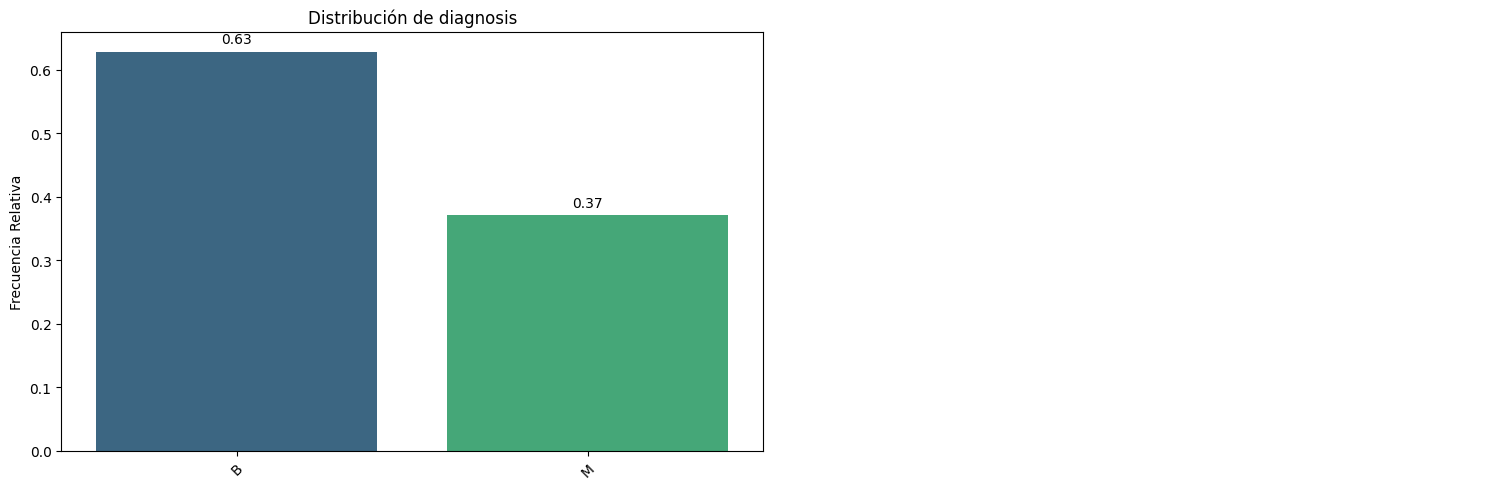

In [8]:
bt.pinta_distribucion_categoricas(train_set, [target], True, True)

In [9]:
# Está ligeramente desbalanceado

### Ejercicio 5: MiniEDA (II)

Analiza bivariantemente las variables contra el target, de forma que veamos las distintas distribuciones para cada clase (puedes emplear la libería gráfica que crees conveniente)

In [10]:
features_num = [col for col in train_set.columns if col != target]

In [11]:
len(features_num)

25

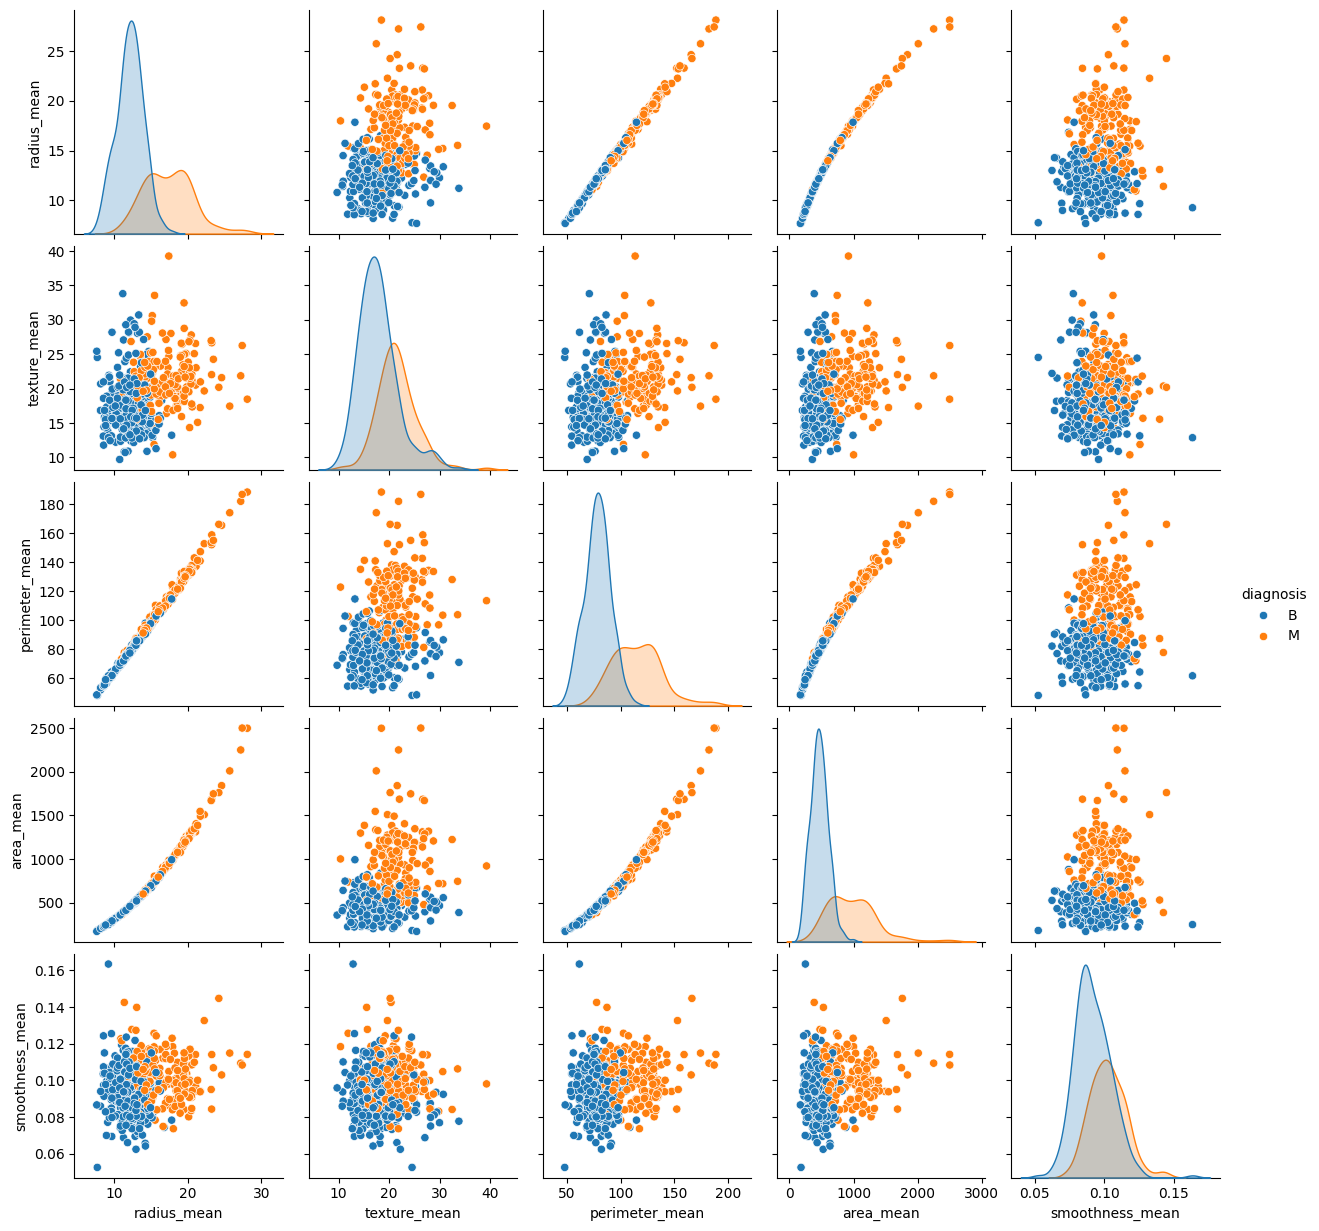

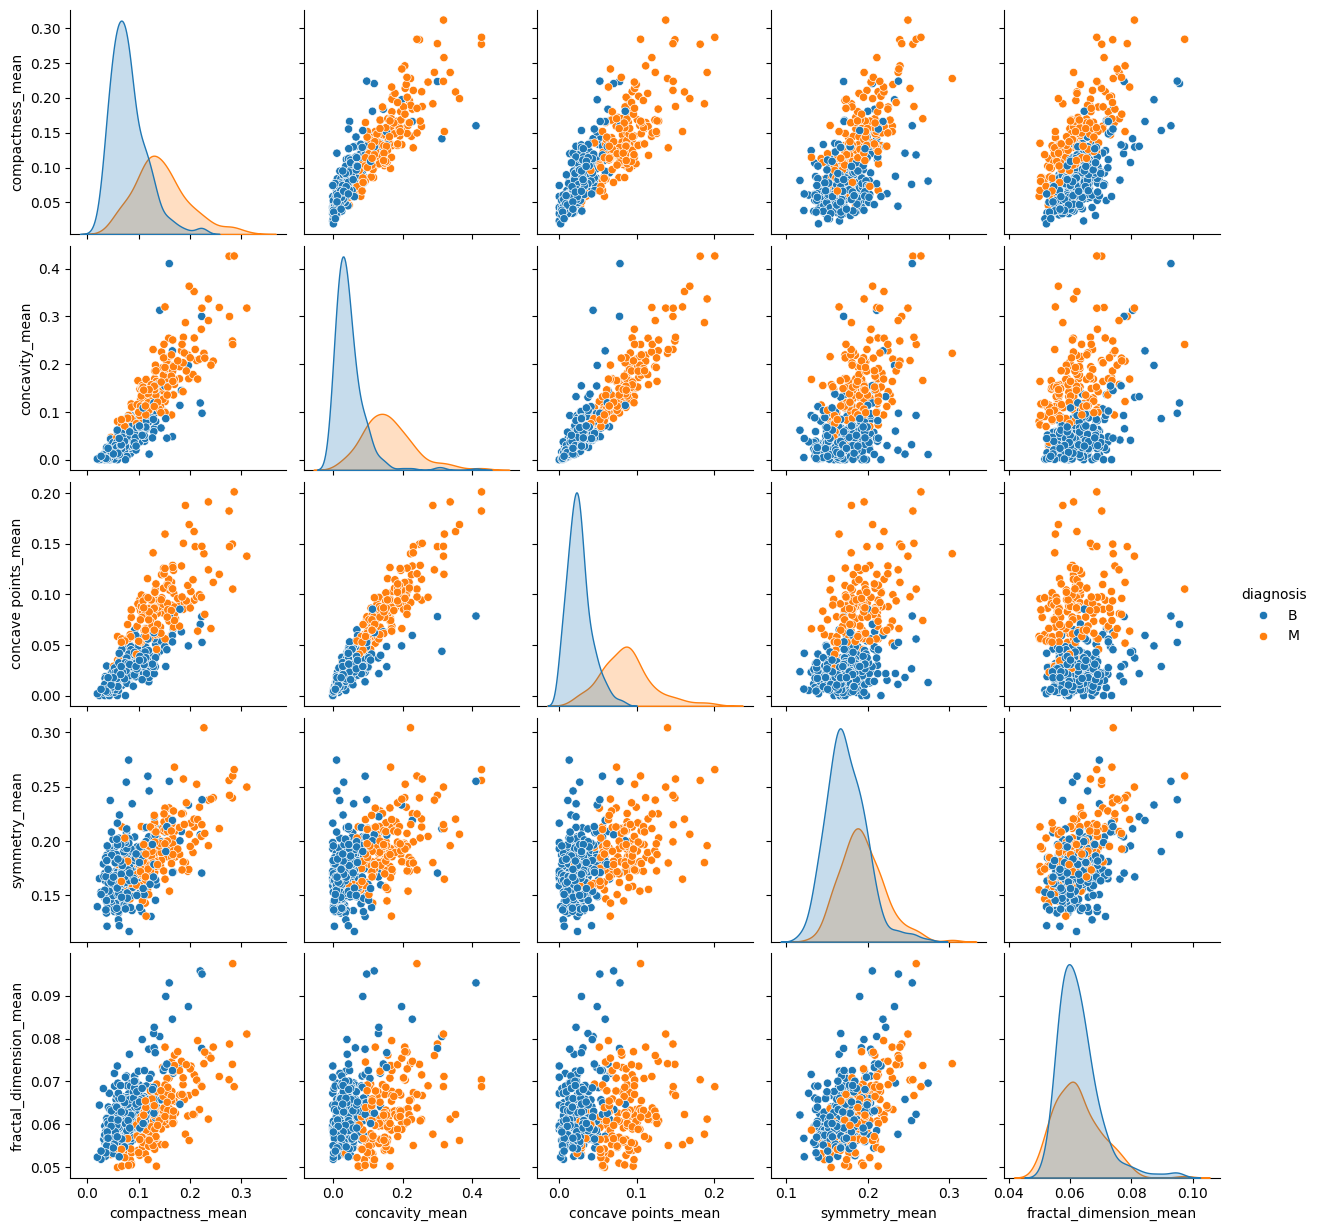

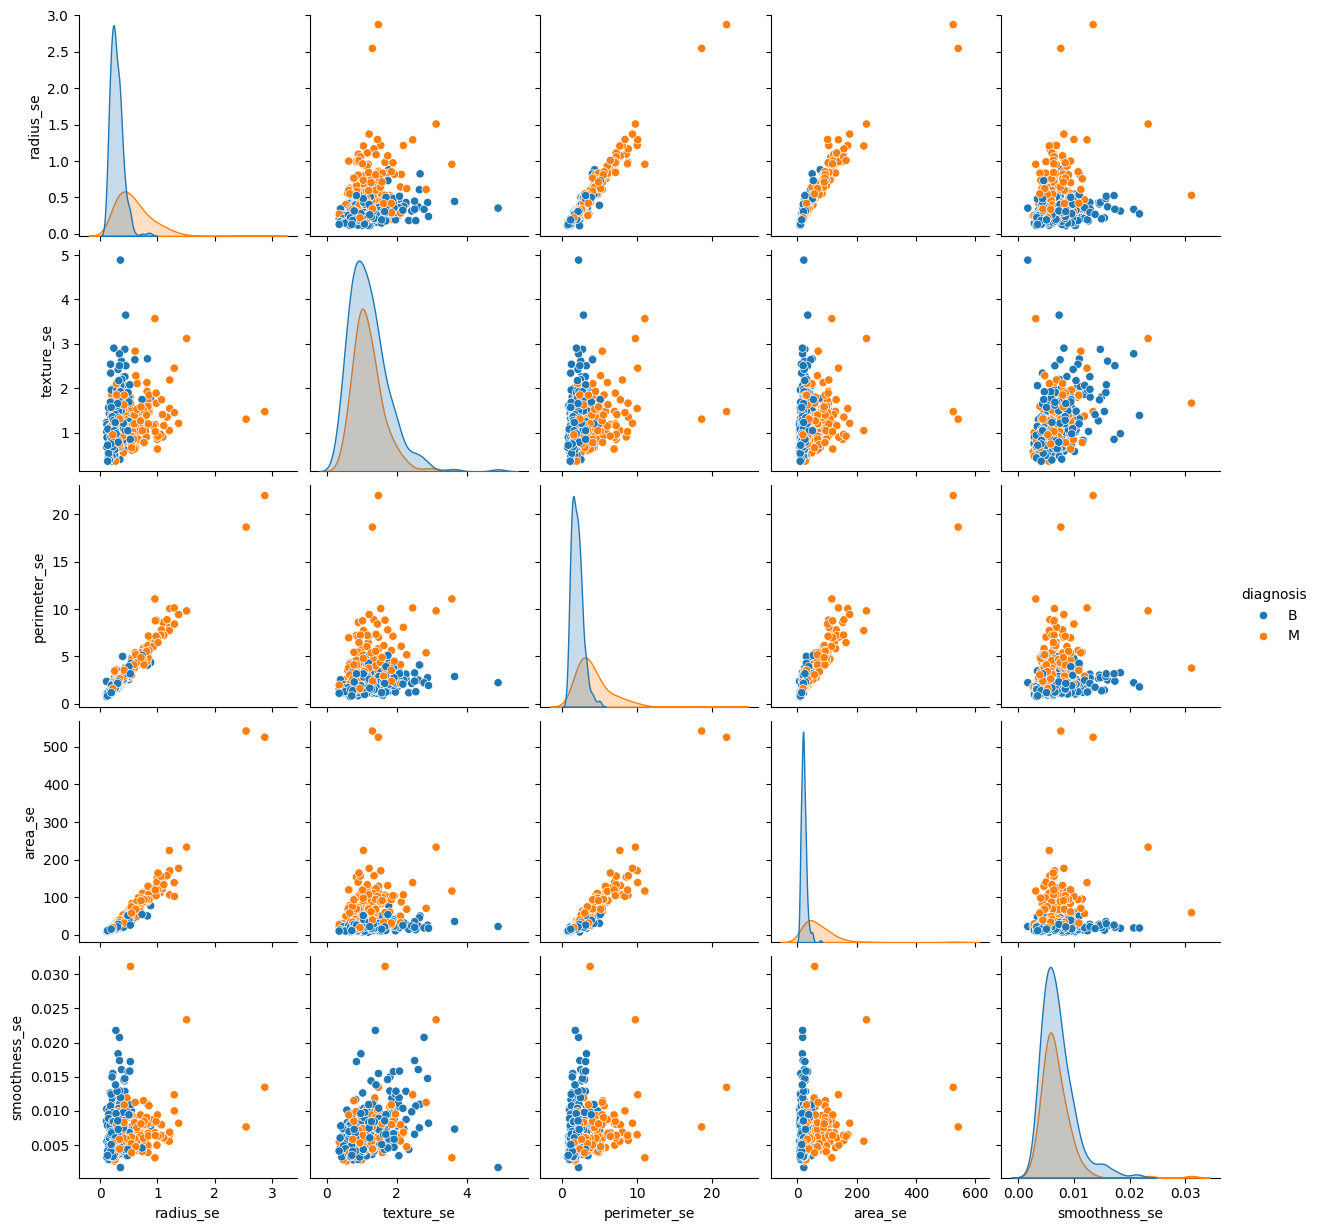

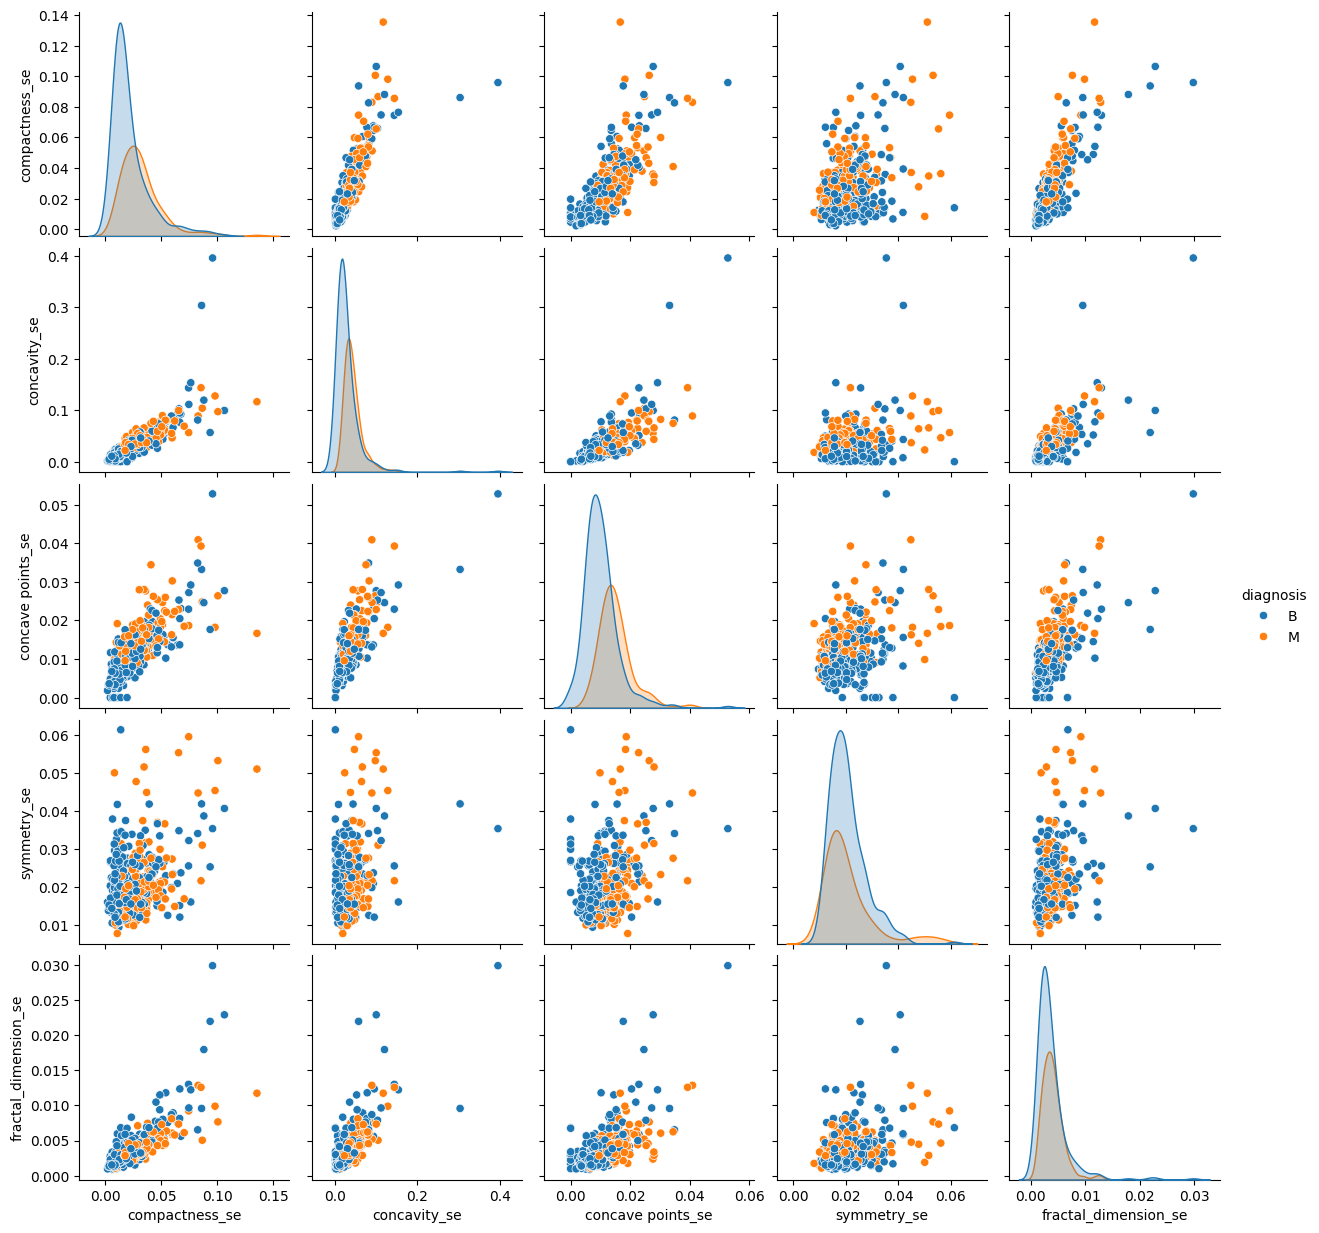

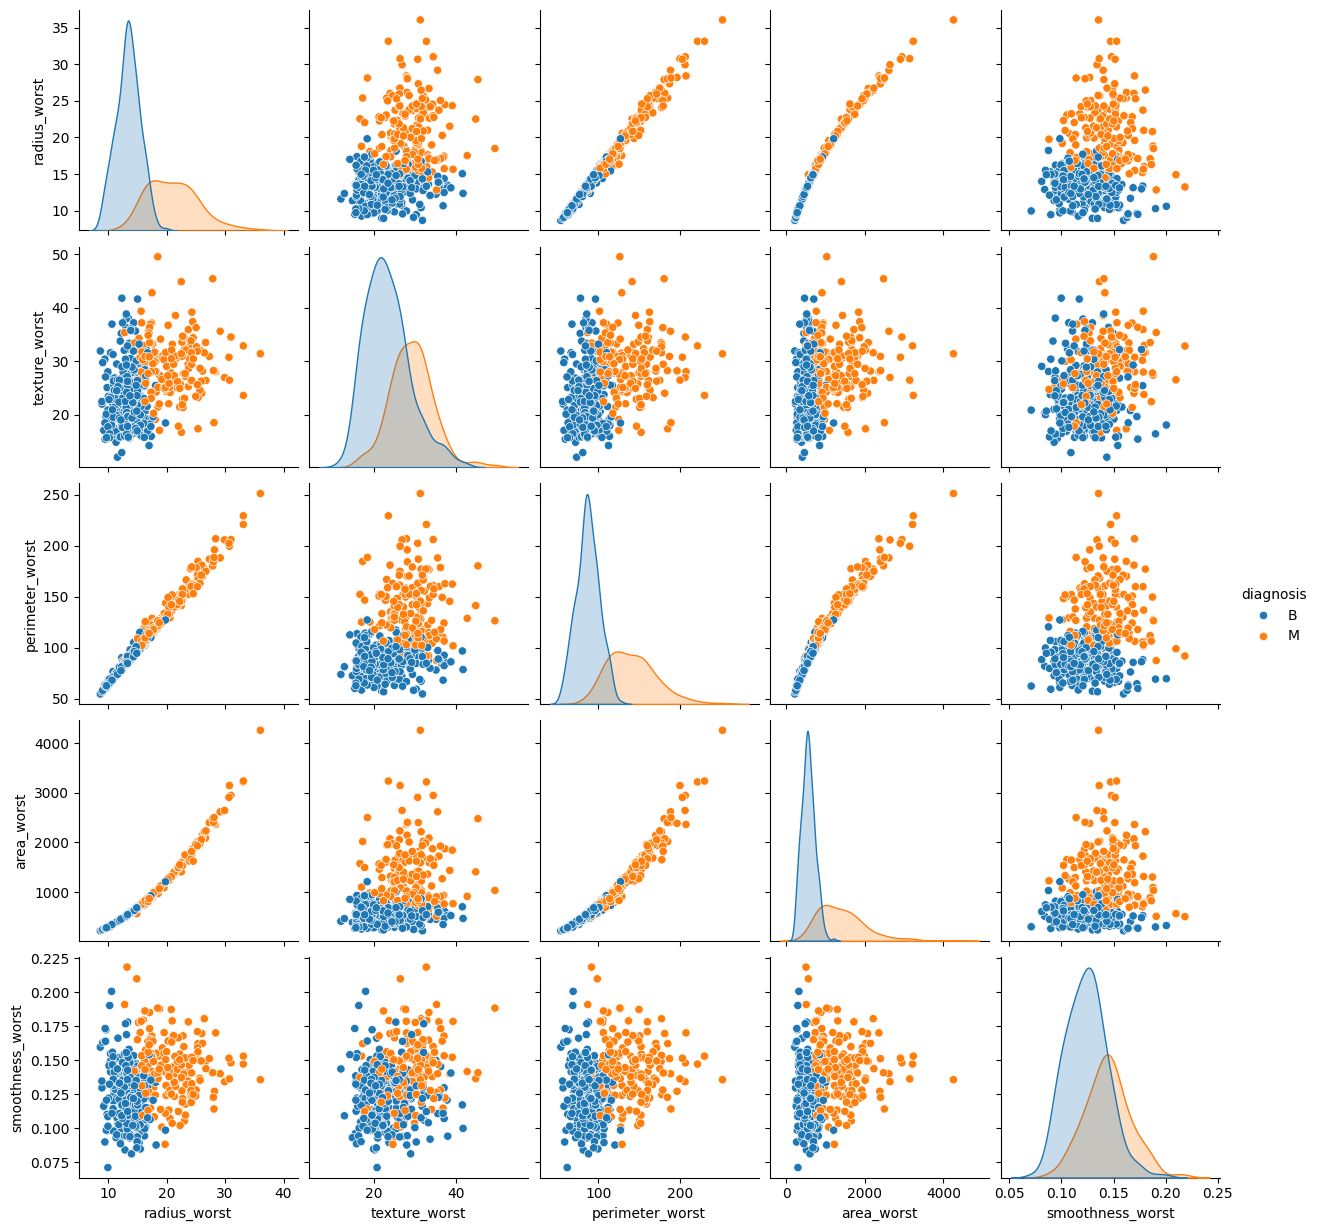

In [12]:
for i in range(0, len(features_num), 5):
    sns.pairplot(train_set[features_num[i:i+5] + [target]], hue=target)

In [13]:
features_num

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst']

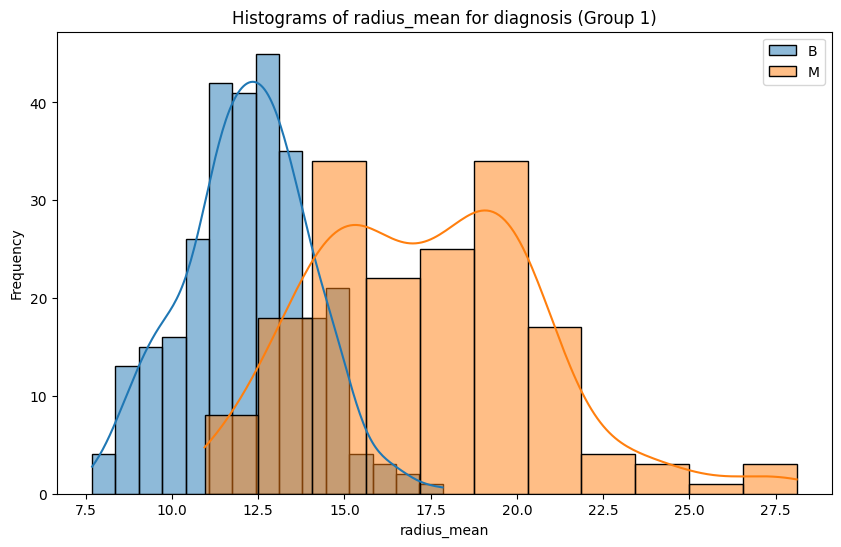

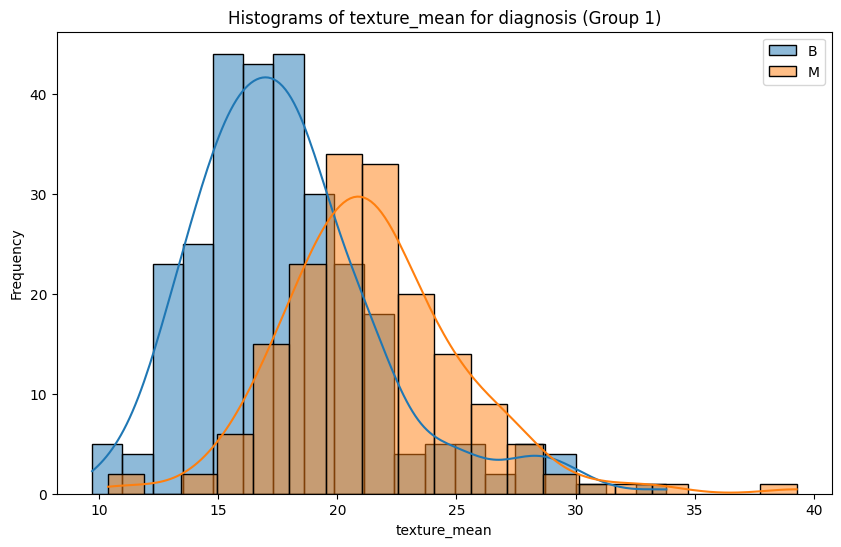

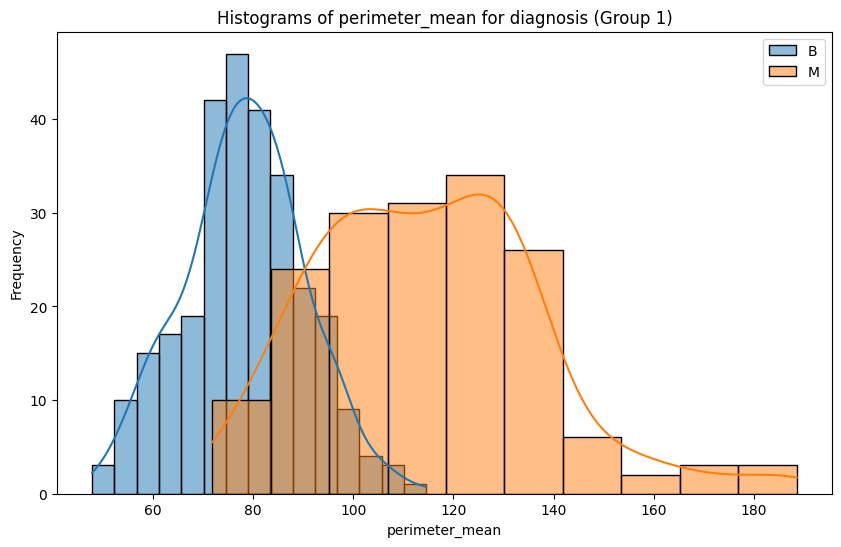

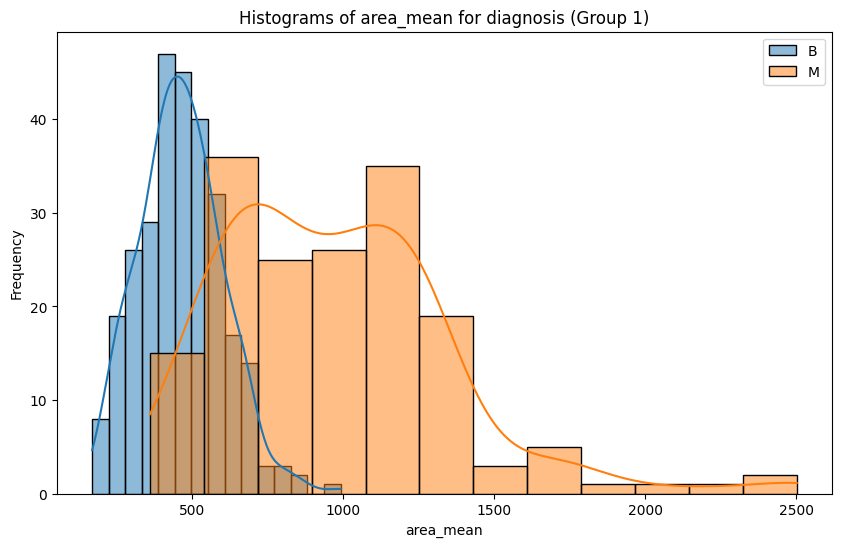

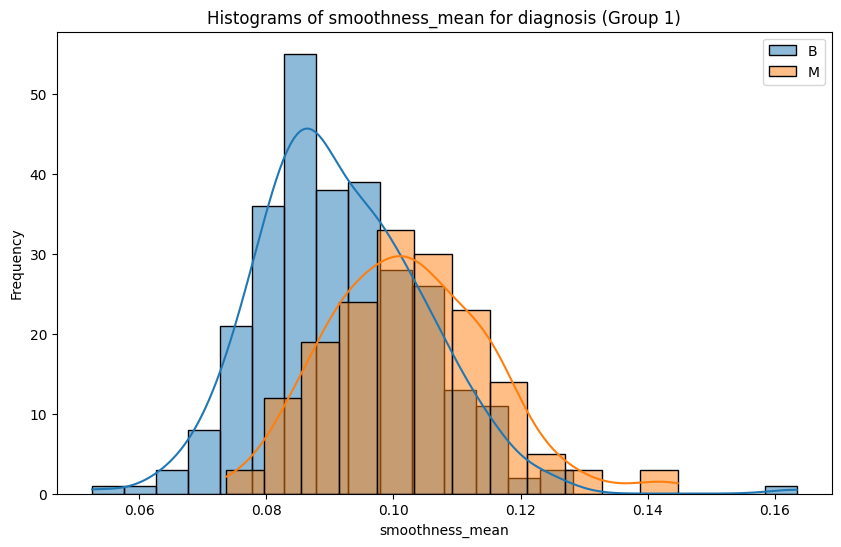

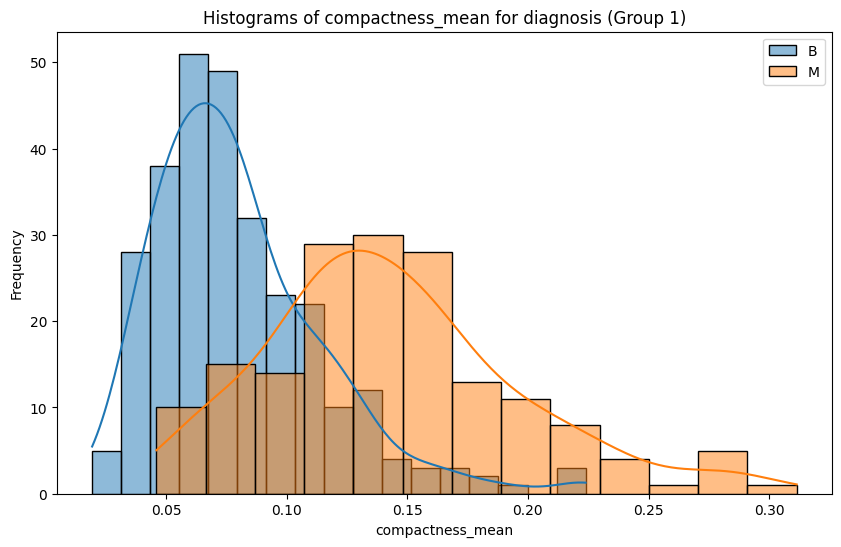

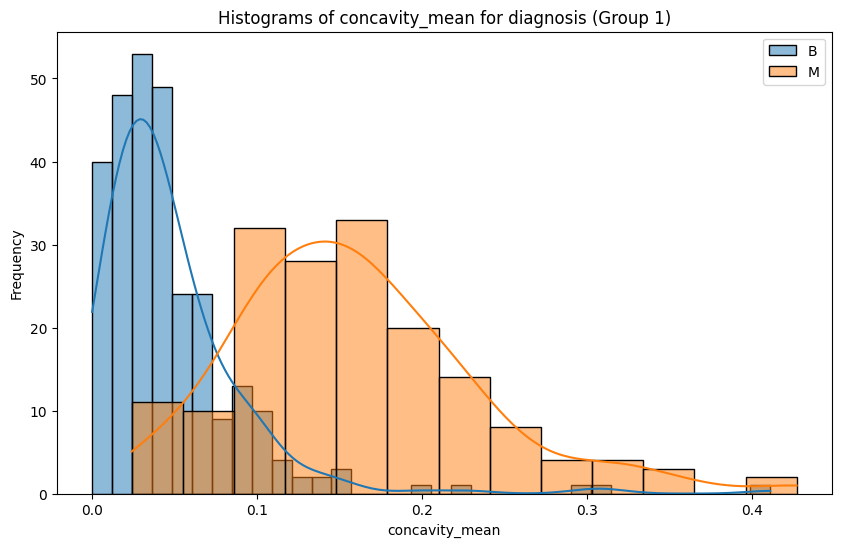

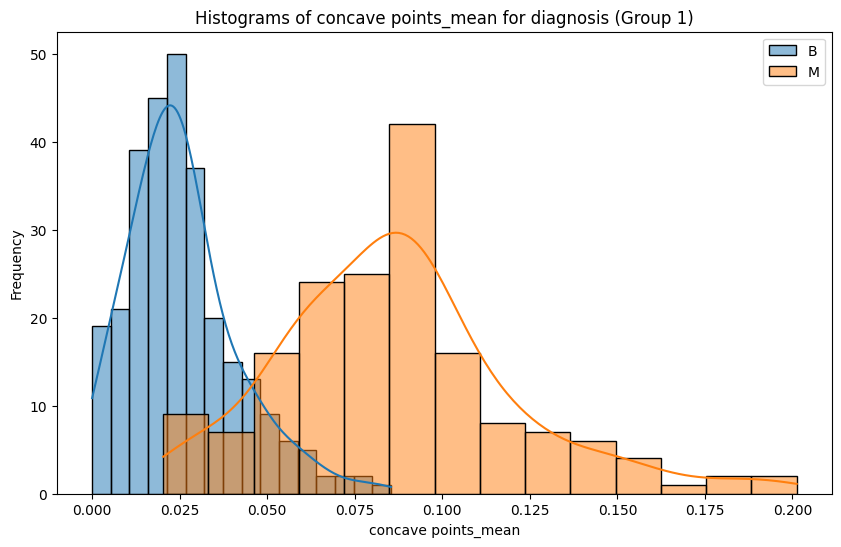

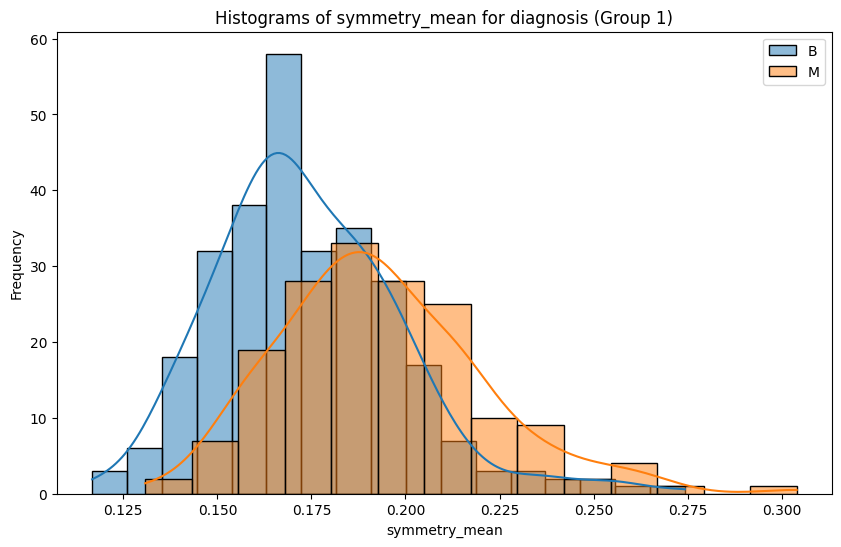

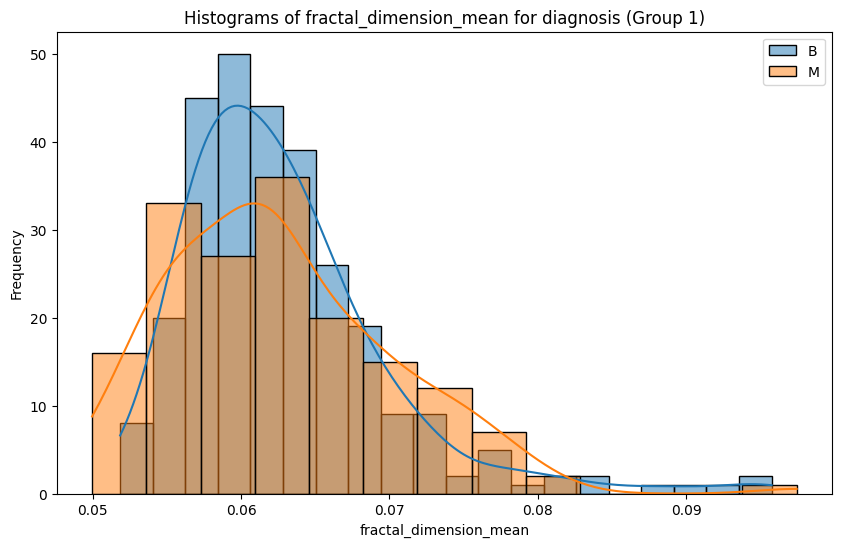

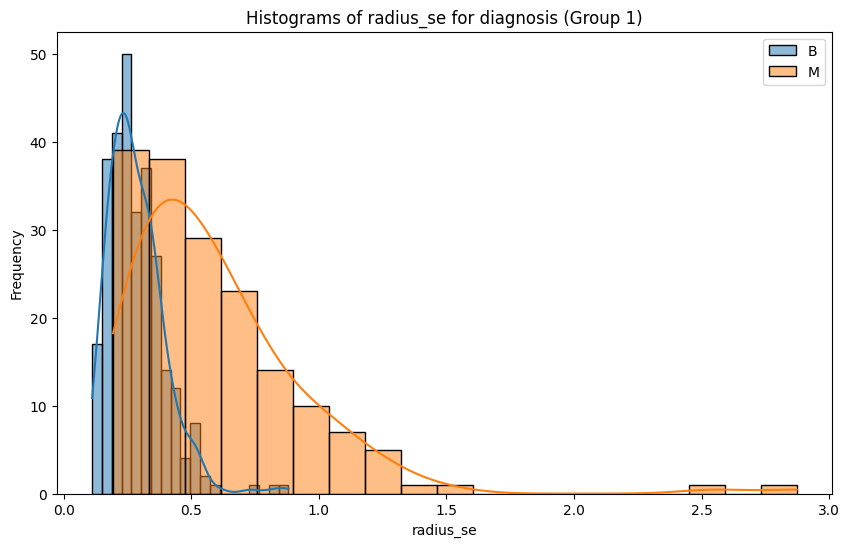

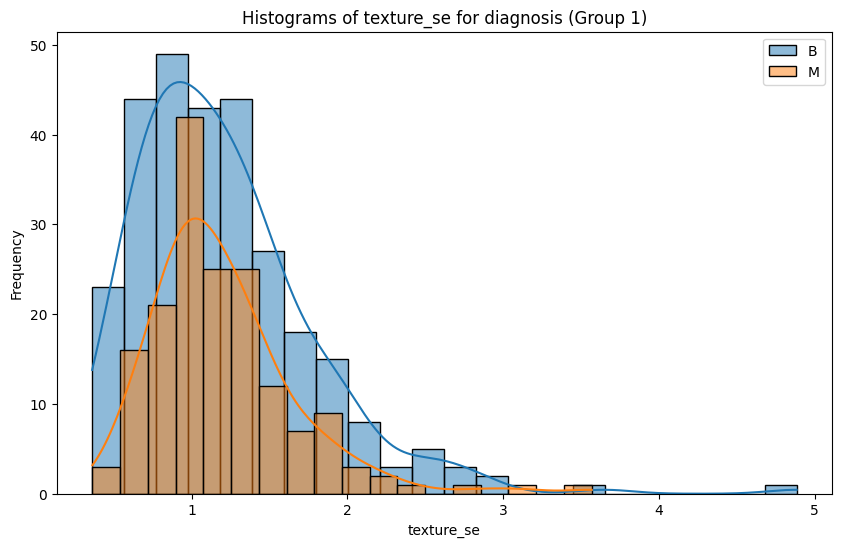

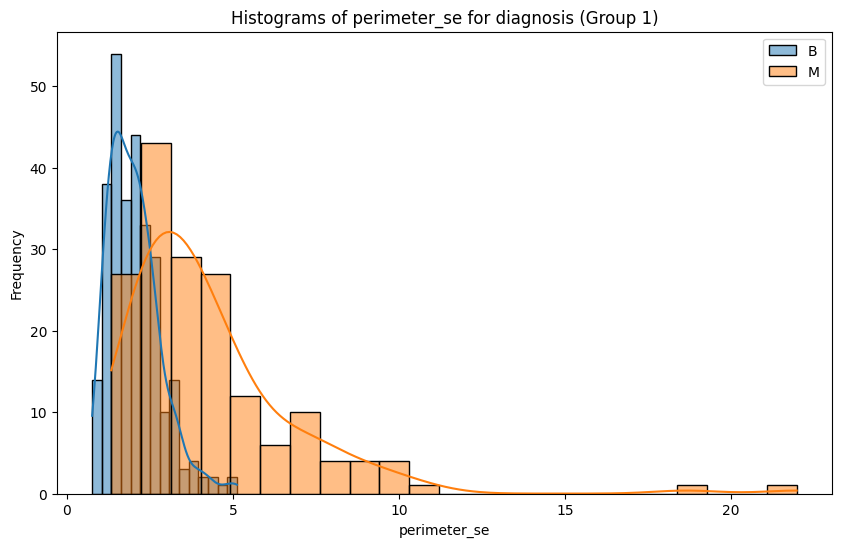

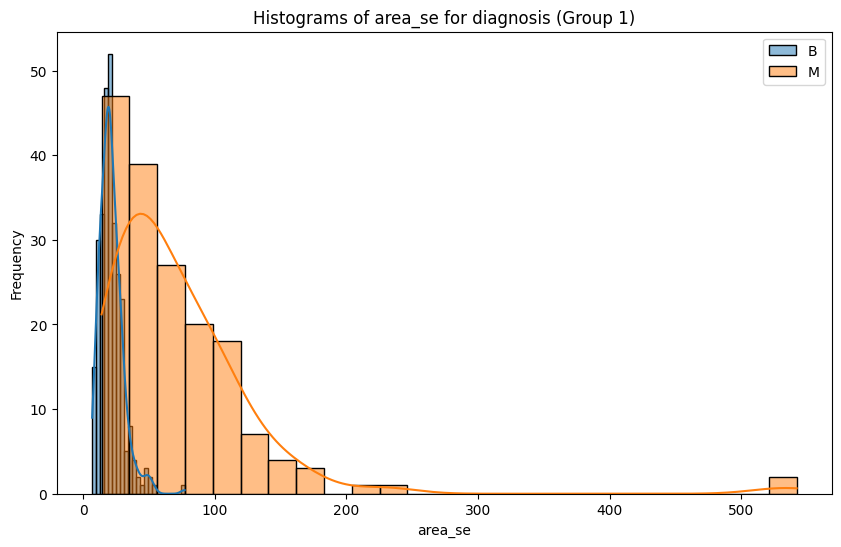

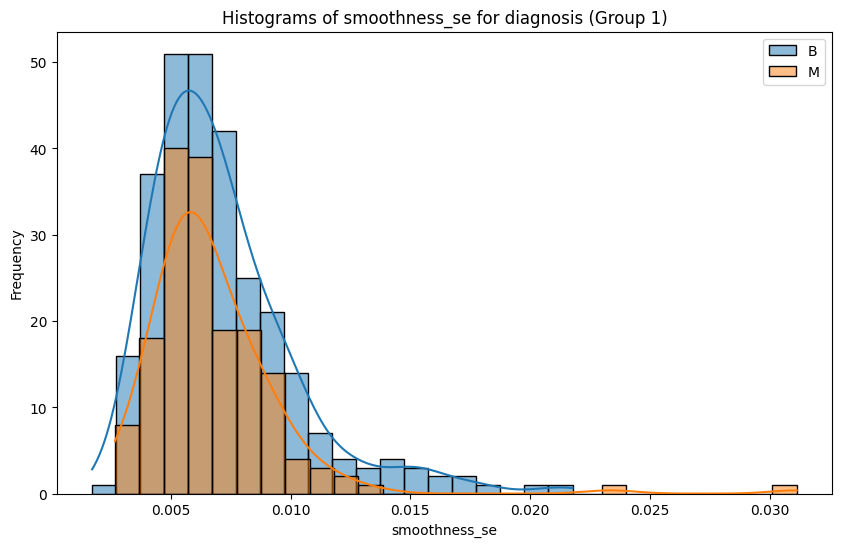

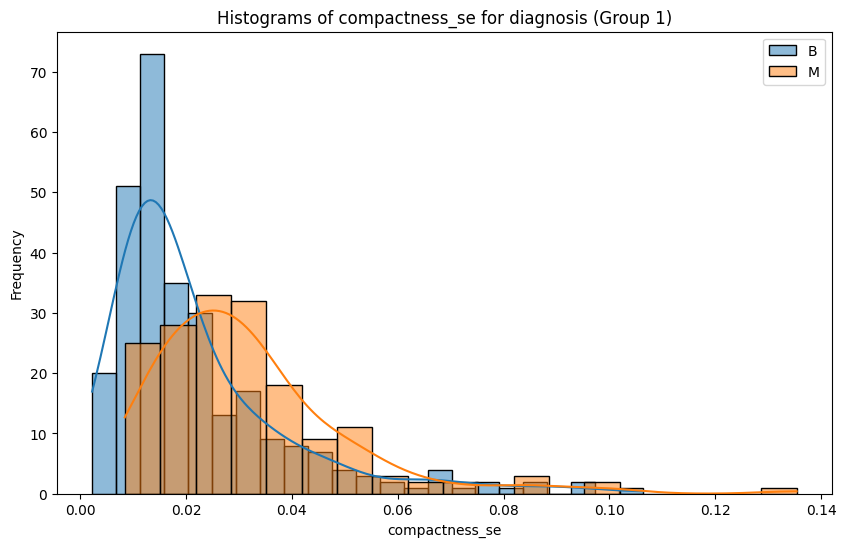

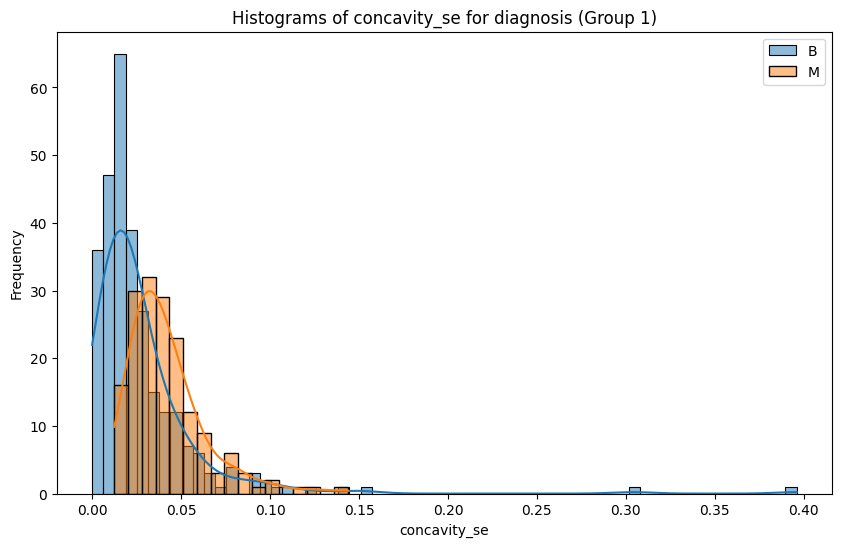

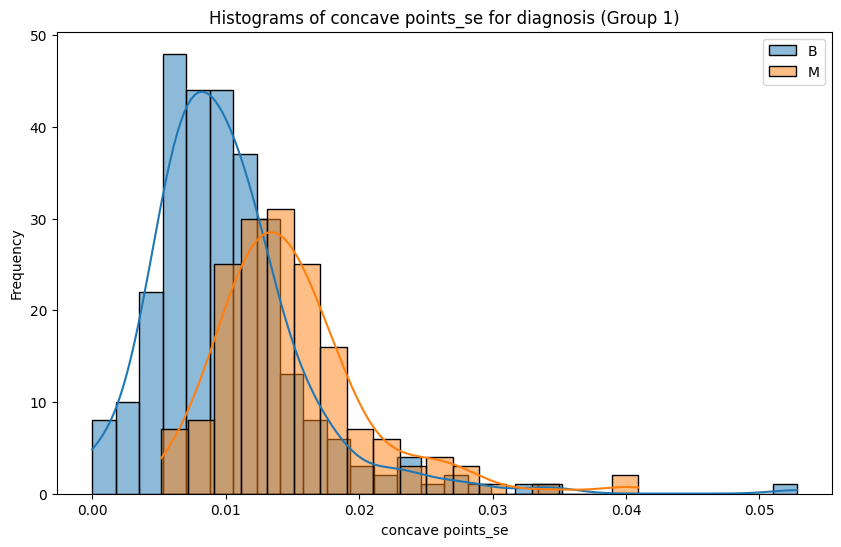

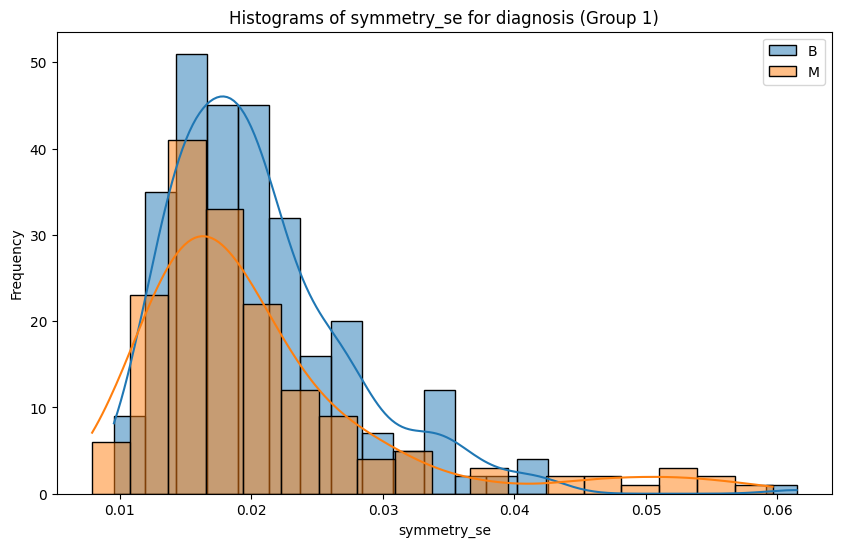

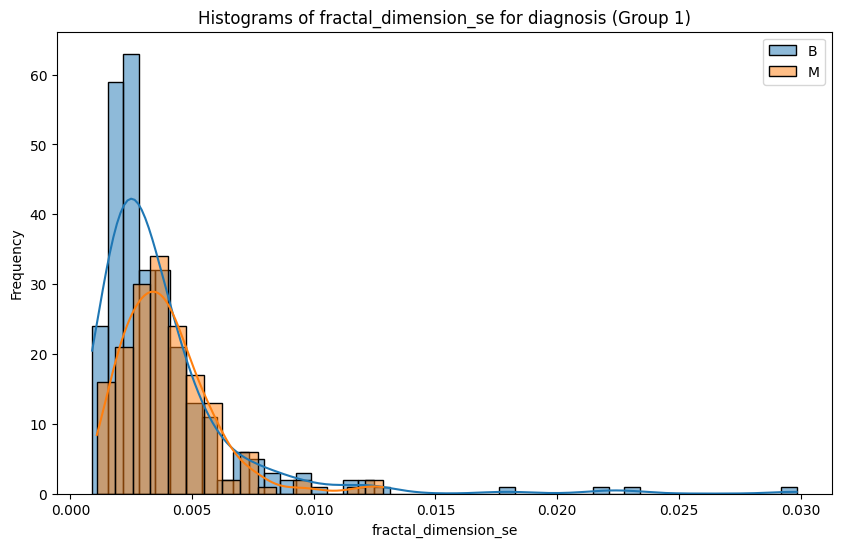

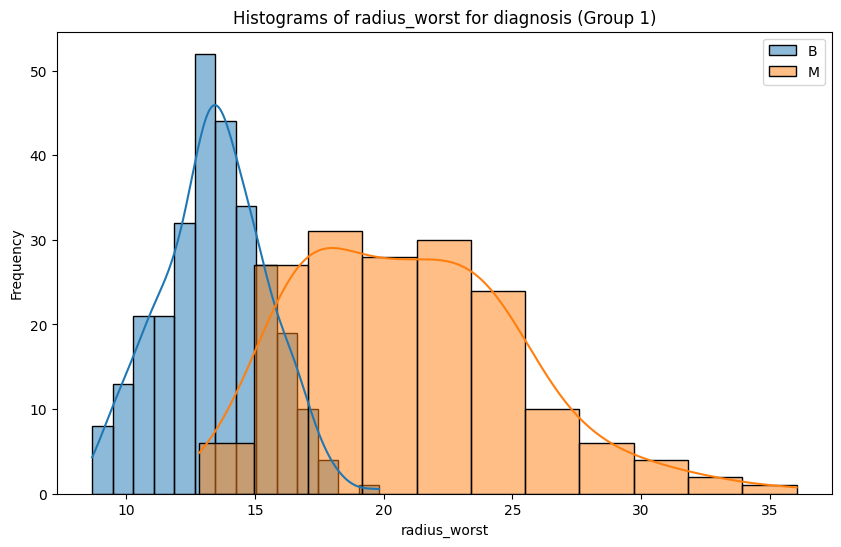

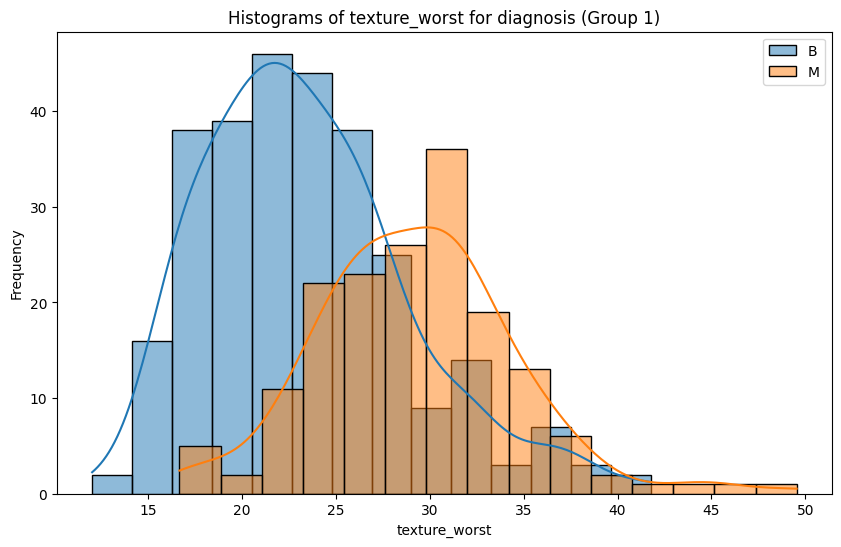

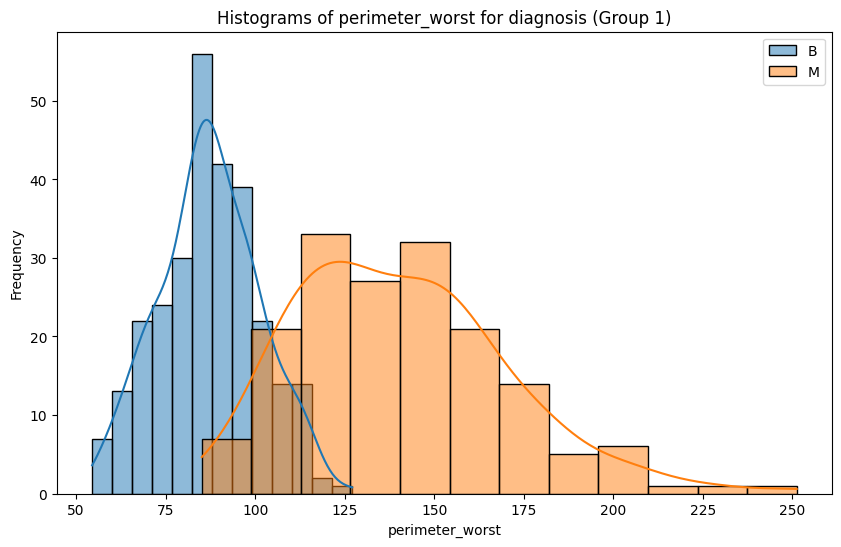

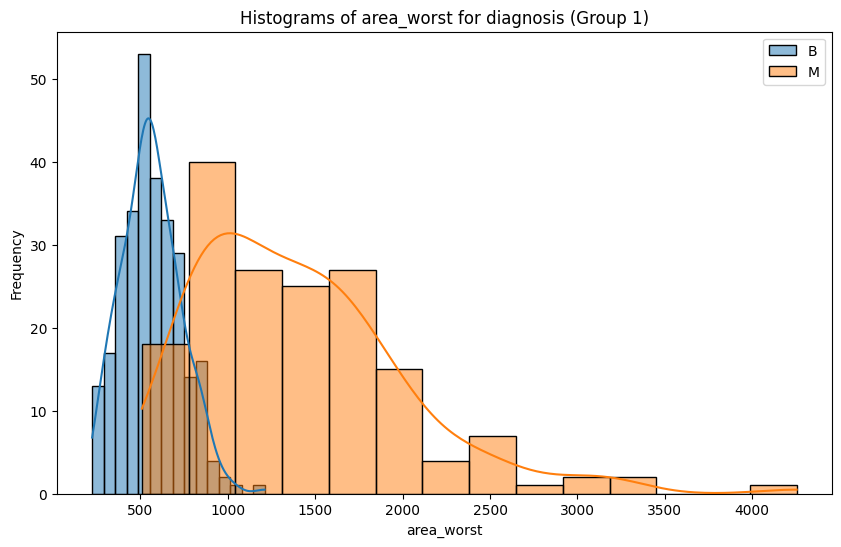

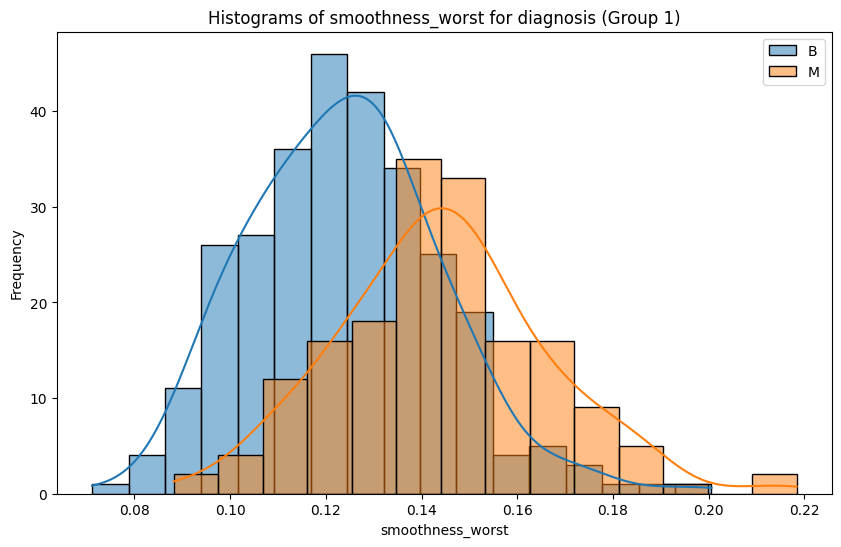

In [14]:
# Para ver mas en detalle
for col in features_num:
    bt.plot_grouped_histograms(train_set, cat_col= target, num_col= col, group_size= 2) 

### Ejercicio 6: MiniEDA (III)

Crea una variable de tipo lista a la que asignes los valores de las columnas que creas conveniente emplear como features en función de lo visto en el miniEDA. Haz una lista de modelos/algoritmos que vas a emplear para hacer el modelo (solo los nombres). En función de la lista anterior, ¿tienes que tratar las variables, por qué?

In [15]:
features_num

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst']

In [16]:
poca_relacion = ["texture_se", "smoothness_se", "symmetry_se", "fractal_dimension_se"]

features_interesantes = [col for col in features_num if col not in poca_relacion]

In [17]:
np.abs(df[features_interesantes].corr(numeric_only = True)).T

radius_mean  texture_mean  perimeter_mean  area_mean  \
radius_mean                1.000000      0.323782        0.997855   0.987357   
texture_mean               0.323782      1.000000        0.329533   0.321086   
perimeter_mean             0.997855      0.329533        1.000000   0.986507   
area_mean                  0.987357      0.321086        0.986507   1.000000   
smoothness_mean            0.170581      0.023389        0.207278   0.177028   
compactness_mean           0.506124      0.236702        0.556936   0.498502   
concavity_mean             0.676764      0.302418        0.716136   0.685983   
concave points_mean        0.822529      0.293464        0.850977   0.823269   
symmetry_mean              0.147741      0.071401        0.183027   0.151293   
fractal_dimension_mean     0.311631      0.076437        0.261477   0.283110   
radius_se                  0.679090      0.275869        0.691765   0.732562   
perimeter_se               0.674172      0.281673        0.693135   0.726628   
area_se                    0.735864      0.259845        0.744983   0.800086   
compactness_se             0.206000      0.191975        0.250744   0.212583   
concavity_se               0.194204      0.143293        0.228082   0.207660   
concave points_se          0.376169      0.163851        0.407217   0.372320   
radius_worst               0.969539      0.352573        0.969476   0.962746   
texture_worst              0.297008      0.912045        0.303038   0.287489   
perimeter_worst            0.965137      0.358040        0.970387   0.959120   
area_worst                 0.941082      0.343546        0.941550   0.959213   
smoothness_worst           0.119616      0.077503        0.150549   0.123523   

                        smoothness_mean  compactness_mean  concavity_mean  \
radius_mean                    0.170581          0.506124        0.676764   
texture_mean                   0.023389          0.236702        0.302418   
perimeter_mean                 0.207278          0.556936        0.716136   
area_mean                      0.177028          0.498502        0.685983   
smoothness_mean                1.000000          0.659123        0.521984   
compactness_mean               0.659123          1.000000        0.883121   
concavity_mean                 0.521984          0.883121        1.000000   
concave points_mean            0.553695          0.831135        0.921391   
symmetry_mean                  0.557775          0.602641        0.500667   
fractal_dimension_mean         0.584792          0.565369        0.336783   
radius_se                      0.301467          0.497473        0.631925   
perimeter_se                   0.296092          0.548905        0.660391   
area_se                        0.246552          0.455653        0.617427   
compactness_se                 0.318943          0.738722        0.670279   
concavity_se                   0.248396          0.570517        0.691270   
concave points_se              0.380676          0.642262        0.683260   
radius_worst                   0.213120          0.535315        0.688236   
texture_worst                  0.036072          0.248133        0.299879   
perimeter_worst                0.238853          0.590210        0.729565   
area_worst                     0.206718          0.509604        0.675987   
smoothness_worst               0.805324          0.565541        0.448822   

                        concave points_mean  symmetry_mean  \
radius_mean                        0.822529       0.147741   
texture_mean                       0.293464       0.071401   
perimeter_mean                     0.850977       0.183027   
area_mean                          0.823269       0.151293   
smoothness_mean                    0.553695       0.557775   
compactness_mean                   0.831135       0.602641   
concavity_mean                     0.921391       0.500667   
concave points_mean                1.000000       0.462497   
symmetry_m

In [18]:
# RandomForest, XGBoost, LightGBM y regresión logística

### Ejercicio 7: Tratamiento de features

Trata las features de manera que puedan ser empleadas por los modelos que escogite en el ejercicio anterior. Recuerda que este es un paso necesario porque los modelos no entienden de primeras de "letras" (salvo alguno que no es que entienda sino que hace sus transformaciones por dentro) y porque en determinados algoritmos es necesario que los rangos de las features estén escalados para que el algoritmo no se decante (érroneamente) por alguna feature sólo porque sus valores son mayores en rango que el de otras. NOTA: Recuerda que lo que le hagas al train, se lo tienes que hacer al test

In [19]:
# Convertir el target a una variable numérica
train_set[target] = train_set[target].map({'M': 1, 'B': 0})
test_set[target] = test_set[target].map({'M': 1, 'B': 0})

# Calcular la correlación de las características numéricas con el target
train_set[features_interesantes + [target]].corr()[target].sort_values(ascending=False)

diagnosis                 1.000000
concave points_mean       0.778115
perimeter_worst           0.774998
radius_worst              0.766527
perimeter_mean            0.731859
area_worst                0.722875
radius_mean               0.718073
area_mean                 0.695171
concavity_mean            0.683262
compactness_mean          0.590554
radius_se                 0.540126
perimeter_se              0.529211
area_se                   0.517064
texture_worst             0.467479
smoothness_worst          0.430364
texture_mean              0.416213
concave points_se         0.380240
smoothness_mean           0.375137
symmetry_mean             0.348123
compactness_se            0.254370
concavity_se              0.216047
fractal_dimension_mean   -0.014308
Name: diagnosis, dtype: float64

In [20]:
train_set[features_num+[target]].corr()[target].sort_values(ascending=False)

diagnosis                 1.000000
concave points_mean       0.778115
perimeter_worst           0.774998
radius_worst              0.766527
perimeter_mean            0.731859
area_worst                0.722875
radius_mean               0.718073
area_mean                 0.695171
concavity_mean            0.683262
compactness_mean          0.590554
radius_se                 0.540126
perimeter_se              0.529211
area_se                   0.517064
texture_worst             0.467479
smoothness_worst          0.430364
texture_mean              0.416213
concave points_se         0.380240
smoothness_mean           0.375137
symmetry_mean             0.348123
compactness_se            0.254370
concavity_se              0.216047
fractal_dimension_se      0.041727
symmetry_se               0.004723
texture_se               -0.003226
fractal_dimension_mean   -0.014308
smoothness_se            -0.058123
Name: diagnosis, dtype: float64

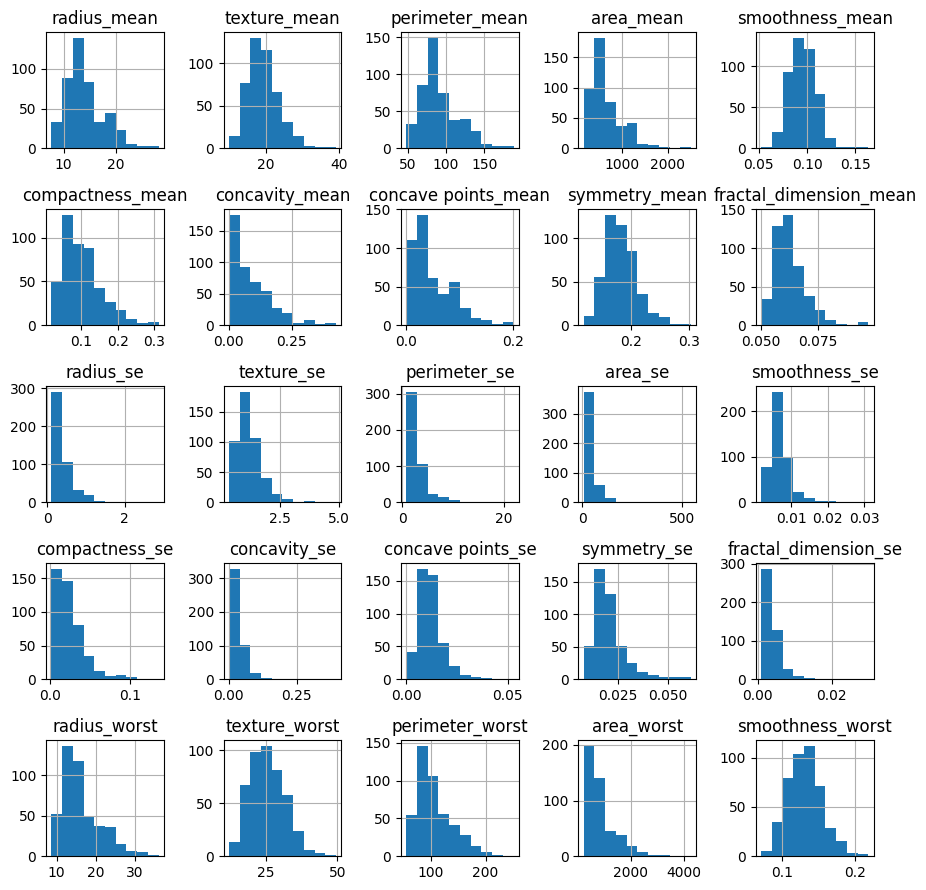

In [22]:
# VEO TODAS
train_set[features_num].hist(figsize = (9,9))
plt.tight_layout()

In [23]:
features_to_transform = ['area_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'perimeter_worst',
 'area_worst']

# Copia
train_set_scaled = train_set.copy()
test_set_scaled = test_set.copy()

# APLICAR TRANSFORMACIÓN LOGARITMICA DE LAS features_to_transform

for col in features_to_transform:
    desplaza = 0 
    if train_set_scaled[col].min() <= 0:
        desplaza = int(abs(train_set_scaled[col].min())) + 1            # Truco para desplazar
    train_set_scaled[col] = np.log(train_set_scaled[col] + desplaza)
    test_set_scaled[col] = np.log(test_set_scaled[col] + desplaza)


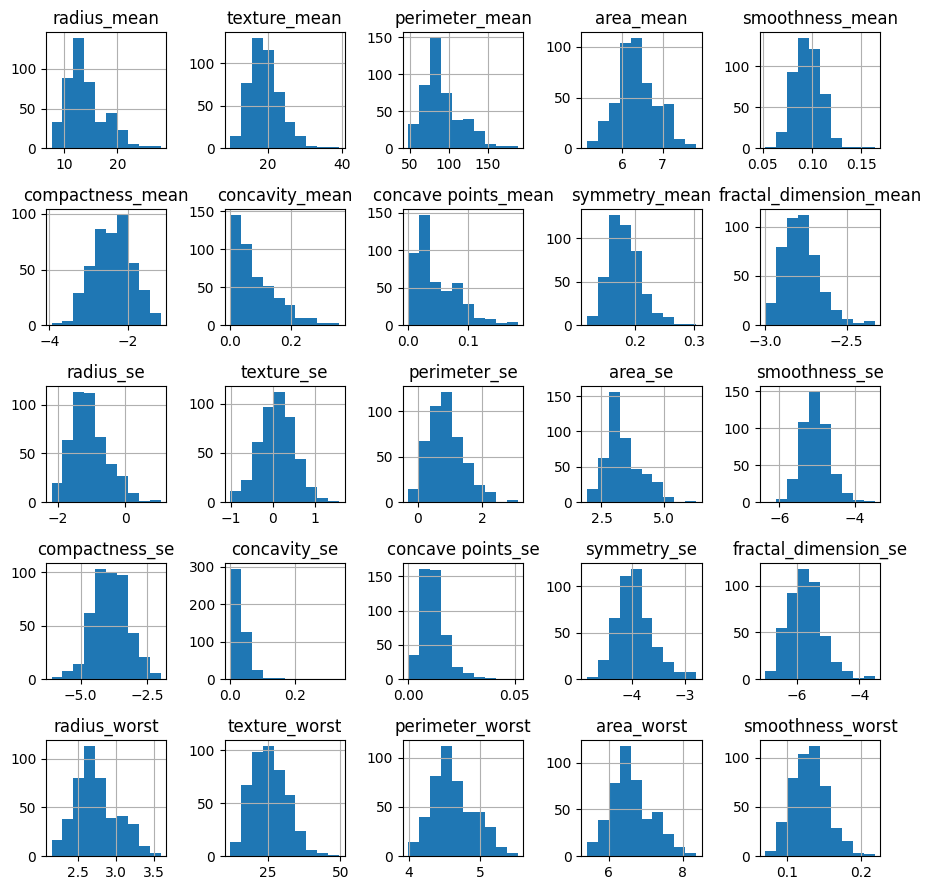

In [24]:
train_set_scaled[features_num].hist(figsize = (9,9))
plt.tight_layout()

In [25]:
train_set_scaled.head()

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
68           0        9.029         17.33           58.79   5.523459   
181          1       21.090         26.57          142.70   7.178545   
63           0        9.173         13.86           59.20   5.564137   
248          0       10.650         25.22           68.01   5.849325   
60           0       10.170         14.88           64.55   5.742683   

     smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
68           0.10660         -1.956870        0.272315             0.042820   
181          0.11410         -1.261602        0.222103             0.139414   
63           0.07721         -2.436002        0.058156             0.021566   
248          0.09657         -2.626378        0.023511             0.016021   
60           0.11340         -2.518133        0.010782             0.012818   

     symmetry_mean  ...  compactness_se  concavity_se  concave points_se  \
68          0.2111  ...       -2.452711      0.265283           0.032680   
181         0.2395  ...       -3.045133      0.037989           0.015548   
63          0.2341  ...       -3.234497      0.042216           0.015480   
248         0.1897  ...       -4.570769      0.010752           0.006226   
60          0.2743  ...       -4.510770      0.007636           0.008160   

     symmetry_se  fractal_dimension_se  radius_worst  texture_worst  \
68     -3.170800             -4.650272      2.333114          22.65   
181    -4.018495             -5.240992      3.283914          33.48   
63     -3.171992             -5.146111      2.303585          19.23   
248    -3.835988             -5.944963      2.505526          35.19   
60     -3.174141             -5.123860      2.399712          17.45   

     perimeter_worst  area_worst  smoothness_worst  
68          4.182050    5.782902           0.14820  
181         5.173321    7.644441           0.14910  
63          4.183423    5.736895           0.09836  
248         4.356452    6.121835           0.14990  
60          4.246493    5.909712           0.12750  

[5 rows x 26 columns]

In [26]:
# ESCALADO
scaler = StandardScaler()

#train_set_scaled[features_interesantes] = scaler.fit_transform(train_set_scaled[features_interesantes])
#test_set_scaled[features_interesantes] = scaler.transform(test_set_scaled[features_interesantes])

# Escalamos TODAS
train_set_scaled[features_num] = scaler.fit_transform(train_set_scaled[features_num])
test_set_scaled[features_num] = scaler.transform(test_set_scaled[features_num])

train_set_scaled.head()

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
68           0    -1.440753     -0.435319       -1.362085  -1.736458   
181          1     1.974096      1.733026        2.091672   1.691938   
63           0    -1.399982     -1.249622       -1.345209  -1.652196   
248          0    -0.981797      1.416222       -0.982587  -1.061450   
60           0    -1.117700     -1.010259       -1.125002  -1.282352   

     smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
68          0.780573          0.864353        2.715841            -0.103746   
181         1.319843          2.252020        1.996819             2.612085   
63         -1.332645         -0.091935       -0.350883            -0.701327   
248         0.059390         -0.471902       -0.846983            -0.857225   
60          1.269511         -0.255857       -1.029272            -0.947293   

     symmetry_mean  ...  compactness_se  concavity_se  concave points_se  \
68        1.092662  ...        2.151631      8.033483           3.376244   
181       2.127004  ...        1.261211      0.211089           0.605509   
63        1.930333  ...        0.976594      0.356564           0.594362   
248       0.313264  ...       -1.031843     -0.726288          -0.902303   
60        3.394436  ...       -0.941663     -0.833534          -0.589508   

     symmetry_se  fractal_dimension_se  radius_worst  texture_worst  \
68      2.273362              2.007011     -1.506389      -0.476309   
181    -0.210216              0.908840      1.948016       1.311279   
63      2.269870              1.085227     -1.613675      -1.040811   
248     0.324493             -0.399867     -0.879991       1.593530   
60      2.263573              1.126594     -1.264430      -1.334616   

     perimeter_worst  area_worst  smoothness_worst  
68         -1.550458   -1.502241          0.722894  
181         1.878377    1.868226          0.761928  
63         -1.545708   -1.585540         -1.438693  
248        -0.947195   -0.888576          0.796624  
60         -1.327547   -1.272641         -0.174876  

[5 rows x 26 columns]

### Ejercicio 8: Creación de los dataset de train y test

Crea las parejas X,y de train y test.

In [27]:
print(len(features_num))
print(len(features_interesantes))
print(len(poca_relacion))
print(len(train_set.columns))

25
21
4
26


In [28]:
# Creación de diversos X dependiendo de las features a seleccionar

# TRAIN SET
X_train_all = train_set[features_num] # Todas las features sin escalar train_set
X_train_scaled = train_set_scaled[features_num] # Todas las features escaladas train_set

X_train_1 = train_set[features_interesantes] # Selección de las features mas importantes sin escalar train_set
X_train_scaled_1 = train_set_scaled[features_interesantes] # Selección de las mas importantes escaladas train_set

y_train = train_set[target] # Target

# TEST SET
X_test_all = test_set[features_num] # Todas las features sin escalar test_set
X_test_scaled = test_set_scaled[features_num] # Todas las features escaladas test_set

X_test_1 = test_set[features_interesantes] # Selección de las features mas importantes sin escalar test_set
X_test_scaled_1 = test_set_scaled[features_interesantes] # Selección de las mas importantes escaladas test_set

y_test = test_set[target] # Target

### Ejercicio 9: Instanciación de modelos

Importa e instancia los modelos que hayas escogido en el ejercicio 6. En general, no hace falta que asignes ahora ningún hiperparámetro salvo en los basados en árboles en los que debes escoger un max_depth para evitar el sobreajuste inicial. Si quieres emplear la regresión logística es posible que tengas que utilizar un valor de max_iter para que el algoritmo converja.

In [29]:
lr_clf = LogisticRegression(max_iter = 1000)
rf_clf = RandomForestClassifier(max_depth= 6, random_state= 42)
lgb_clf = LGBMClassifier(max_depth= 6, random_sate = 42, verbose = -100)
xgb_clf = XGBClassifier(max_depth = 6, random_state = 42)

modelos = {
    "Regresion Logistica": lr_clf,
    "Random Forest": rf_clf,
    "Lightgbm": lgb_clf,
    "XGBoost": xgb_clf
}

### Ejercicio 10: Comparativa de modelos

Haz la comparativa de modelos empleando cross_val_score (es decir la validación cruzada). Utiliza k = 5, y un scoring acorde a la métrica escogida en el ejercicio 1. Si no tienes clara la métrica entonces emplea el recall_medio y usa scoring = "balanced acuracy". Escoge el modelo ganador.

In [ ]:
# Definir la métrica de evaluación
scoring_func = "balanced_accuracy"  # Se usa balanced accuracy

# Diccionario para almacenar los mejores resultados
resultados = {}

# Conjuntos de features (incluyendo escalado para regresión logística)
feature_sets = {
    "Todas las features": (X_train_all, X_train_scaled, X_test_all, X_test_scaled),
    "Features más importantes": (X_train_1, X_train_scaled_1, X_test_1, X_test_scaled_1),
}

# Evaluar cada modelo con cada conjunto de features
for nombre_modelo, modelo in modelos.items():
    print(f"\nModelo: {nombre_modelo}")
    mejores_resultados = {}

    for nombre_feat, (X_train, X_train_scaled, X_test, X_test_scaled) in feature_sets.items():
        # Usar el conjunto escalado solo en la regresión logística
        if nombre_modelo == "Regresion Logistica":
            X_train_val = X_train_scaled
            X_test_val = X_test_scaled
        else:
            X_train_val = X_train
            X_test_val = X_test

        # Validación cruzada con 5 folds
        scores = cross_val_score(modelo, X_train_val, y_train, cv=5, scoring=scoring_func)
        recall_medio = np.mean(scores)

        mejores_resultados[nombre_feat] = recall_medio
        print(f"  {nombre_feat}: Recall Medio = {recall_medio:.4f}")

    # Guardamos el mejor resultado del modelo
    mejor_feature_set = max(mejores_resultados, key=mejores_resultados.get)
    resultados[nombre_modelo] = (mejor_feature_set, mejores_resultados[mejor_feature_set])

# Mostrar el mejor resultado por modelo
print("\n🏆 Mejor score (balanced accuracy) por modelo:")
for modelo, (feat_set, score) in resultados.items():
    print(f"{modelo}: {feat_set} con {score:.4f}")


Modelo: Regresion Logistica
  Todas las features: Recall Medio = 0.9636
  Features más importantes: Recall Medio = 0.9635

Modelo: Random Forest
  Todas las features: Recall Medio = 0.9429
  Features más importantes: Recall Medio = 0.9489

Modelo: Lightgbm
  Todas las features: Recall Medio = 0.9601
  Features más importantes: Recall Medio = 0.9548

Modelo: XGBoost
  Todas las features: Recall Medio = 0.9665
  Features más importantes: Recall Medio = 0.9554

🏆 Mejor score (balanced accuracy) por modelo:
Regresion Logistica: Todas las features con 0.9636
Random Forest: Features más importantes con 0.9489
Lightgbm: Todas las features con 0.9601
XGBoost: Todas las features con 0.9665


In [33]:
# Para scoring precision
scoring_func = make_scorer(precision_score, pos_label = 1)


for nombre_feat, (X_train, X_train_scaled, X_test, X_test_scaled) in feature_sets.items():
   
    print(f"Para el set '{nombre_feat}':")
    
    for tipo,modelo in modelos.items():
        
        print(f"{tipo}: ", end = " ")
        
        if tipo != "Regresion Logistica":
            print(np.mean(cross_val_score(modelo, X_train, y_train, cv = 5, scoring = scoring_func)))
        else:
            print(np.mean(cross_val_score(modelo, X_train_scaled, y_train, cv = 5, scoring = scoring_func)))
    print("   ")


Para el set 'Todas las features':
Regresion Logistica:  0.9760592096075967
Random Forest:  0.9459436633891093
Lightgbm:  0.9638798701298701
XGBoost:  0.9755570409982175
   
Para el set 'Features más importantes':
Regresion Logistica:  0.9761029411764707
Random Forest:  0.9464580509623204
Lightgbm:  0.9483431518127793
XGBoost:  0.9580211439414477
   


### Ejercicio 11: Ajuste de hiperparámetros

Escoge un grid para ajustar los hiperparámetros de tu modelo. Crea un objeto GridSearch y "ajustalo" (emplea su método fit) para encontrar la mejor combinaciónde hiperparámetros empleando la métrica que decidimos en el ejercio 1. Si no lo tienes claro emplea "balance accuracy". Por otro lado, incluye en el grid, el hiperparámetro que permita que el modelo "compense" el desbalanceo del dataset de entrada, aunque este no lo tenga.

In [34]:
# Definir la métrica de evaluación
scoring_func = "balanced_accuracy"  # Se usa balanced accuracy

# Diccionario para almacenar los mejores resultados
resultados = {}

# Hiperparámetros para cada modelo
param_grid = {
    "Regresion Logistica": {
        "C": [0.01, 0.1, 1, 10, 100],
        "solver": ["liblinear", "lbfgs"],
        "class_weight": ["balanced", None]  # Se agrega class_weight=balanced
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 5, 10, None],
        "class_weight": ["balanced", None]  # Se agrega class_weight=balanced
    },
    "Lightgbm": {
        "num_leaves": [10, 20, 30],
        "learning_rate": [0.01, 0.1, 0.2],
        "n_estimators": [50, 100, 200],
        "scale_pos_weight": [1, 2, 5]  # Escala de ponderación para tratar el desbalanceo
    },
    "XGBoost": {
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7],
        "n_estimators": [50, 100, 200],
        "scale_pos_weight": [1, 2, 5]  # Escala de ponderación para tratar el desbalanceo
    }
}


In [35]:
# Conjuntos de features (incluyendo escalado para regresión logística)
feature_sets = {
    "Todas las features": (X_train_all, X_train_scaled, X_test_all, X_test_scaled),
    "Features más importantes": (X_train_1, X_train_scaled_1, X_test_1, X_test_scaled_1),
}

# Evaluar cada modelo con cada conjunto de features
for nombre_modelo, modelo in modelos.items():
    print(f"\n🔍 Ajustando modelo: {nombre_modelo}")
    mejores_resultados = {}

    for nombre_feat, (X_train, X_train_scaled, X_test, X_test_scaled) in feature_sets.items():
        # Usar el conjunto escalado solo en la regresión logística
        if nombre_modelo == "Regresion Logistica":
            X_train_usar = X_train_scaled
            X_test_usar = X_test_scaled
        else:
            X_train_usar = X_train
            X_test_usar = X_test

        # GridSearchCV para encontrar los mejores hiperparámetros
        grid_search = GridSearchCV(
            modelo,
            param_grid[nombre_modelo],
            cv=5,
            scoring=scoring_func,
            n_jobs=-1
        )

        grid_search.fit(X_train_usar, y_train)
        best_score = grid_search.best_score_
        best_params = grid_search.best_params_

        mejores_resultados[nombre_feat] = (best_score, best_params)
        print(f"  {nombre_feat}: Mejor Recall Medio = {best_score:.4f}, Hiperparámetros = {best_params}")

    # Guardamos el mejor resultado del modelo
    mejor_feature_set = max(mejores_resultados, key=lambda k: mejores_resultados[k][0])
    resultados[nombre_modelo] = (mejor_feature_set, *mejores_resultados[mejor_feature_set])

# Mostrar el mejor resultado por modelo
print("\n🏆 Mejor configuración por modelo:")
for modelo, (feat_set, score, params) in resultados.items():
    print(f"{modelo}: {feat_set} con {score:.4f}, Hiperparámetros óptimos: {params}")


🔍 Ajustando modelo: Regresion Logistica
  Todas las features: Mejor Recall Medio = 0.9707, Hiperparámetros = {'C': 1, 'class_weight': 'balanced', 'solver': 'lbfgs'}
  Features más importantes: Mejor Recall Medio = 0.9707, Hiperparámetros = {'C': 1, 'class_weight': 'balanced', 'solver': 'lbfgs'}

🔍 Ajustando modelo: Random Forest
  Todas las features: Mejor Recall Medio = 0.9518, Hiperparámetros = {'class_weight': None, 'max_depth': 10, 'n_estimators': 200}
  Features más importantes: Mejor Recall Medio = 0.9536, Hiperparámetros = {'class_weight': None, 'max_depth': 10, 'n_estimators': 100}

🔍 Ajustando modelo: Lightgbm
  Todas las features: Mejor Recall Medio = 0.9677, Hiperparámetros = {'learning_rate': 0.2, 'n_estimators': 200, 'num_leaves': 20, 'scale_pos_weight': 1}
  Features más importantes: Mejor Recall Medio = 0.9660, Hiperparámetros = {'learning_rate': 0.2, 'n_estimators': 200, 'num_leaves': 10, 'scale_pos_weight': 2}

🔍 Ajustando modelo: XGBoost
  Todas las features: Mejor R

### Ejercicio 12: Evaluación del modelo

Evalúa el modelo contra el dataset de test. Muestra el informe de clasificación y haz una valoración de si el hospital aceptaría el modelo o no.


📝 Informe de clasificación del modelo en el conjunto de test:
              precision    recall  f1-score   support

           0       0.84      0.72      0.77        71
           1       0.62      0.77      0.69        43

    accuracy                           0.74       114
   macro avg       0.73      0.74      0.73       114
weighted avg       0.76      0.74      0.74       114

Accuracy del modelo en el conjunto de prueba: 0.7368


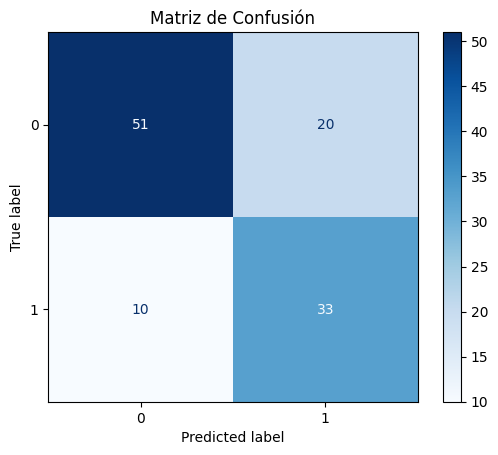

In [39]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Elegimos el mejor modelo y su conjunto de características
mejor_modelo_nombre = "Regresion Logistica"  # Asegúrate de que sea el modelo con mejor rendimiento según los resultados previos
mejor_feature_set = resultados[mejor_modelo_nombre][0]
best_params = resultados[mejor_modelo_nombre][1]

# Seleccionar las características del mejor conjunto de datos (según los resultados anteriores)
if mejor_feature_set == "Todas las features":
    X_test_usar = X_test_scaled
else: # mejor_feature_set == "Features más importantes"
    X_test_usar = X_test_scaled_1

# Ajustamos el modelo con los mejores hiperparámetros
modelo_final = GridSearchCV(modelos[mejor_modelo_nombre], 
                            param_grid[mejor_modelo_nombre], 
                            cv=5, 
                            scoring="balanced_accuracy", 
                            n_jobs=-1)

modelo_final.fit(X_train_usar, y_train)

# Realizamos la predicción sobre el conjunto de test
y_pred = modelo_final.predict(X_test_usar)

# Evaluación del rendimiento del modelo
print("\n📝 Informe de clasificación del modelo en el conjunto de test:")
print(classification_report(y_test, y_pred))

# Obtener la precisión general
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo en el conjunto de prueba: {accuracy:.4f}")

# Matriz de Confusión con ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)

# Visualizar la Matriz de Confusión utilizando ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo_final.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión')
plt.show()

### Ejercicio 13: Análisis de errores

Muestra la matriz de confusión con los porcentajes de precisión (emplea ConfusionMatrixDisplay.from_predictions con el argumento normalize con el valor adecuado). Haz un pequeño análisis.

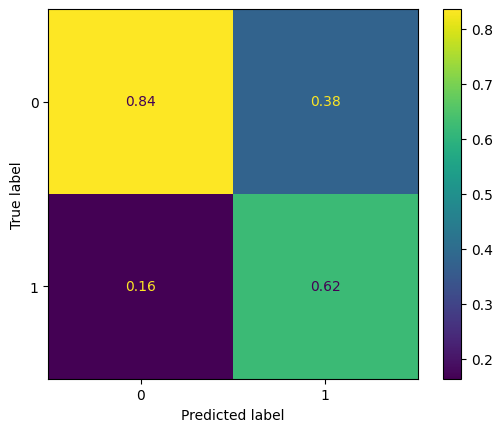

In [40]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize= "pred")

### EXTRA: 

Busca en Internet o pregúntale a tu AI preferida, cómo se graba un modelo en disco y gúardalo en "./models/cancer_pred" con la extesión apropiada.

In [43]:
import pickle

# Creamos el directorio si no existe
os.makedirs("models", exist_ok= True)


# Guardar el modelo en un archivo
with open('cancer_pred.pkl', 'wb') as file:
    pickle.dump(modelo_final.best_estimator_, file)
    print("Modelo guardado con éxito usando pickle")


Modelo guardado con éxito usando pickle


In [44]:
# Para cargarlo

# Cargar el modelo
with open('cancer_pred.pkl', 'rb') as file:
    model = pickle.load(file)

# Ahora 'model' está listo para usarse como antes
y_pred = model.predict(X_train_usar)
